***Fault-Plane Automation Determination [A Machine Learning (ML) Based Algorithm]: For Either Seismological/Earthquake or Microseismic Data, “Swarm-Cloud” Investigations***
We aim, through the use of this Colab/Python algortihm, to determine the location of the defaulted plane within a given event swarm in order to create a product that companies can use to map the location of previous seismic events to reference a possible fault and corresponding directionality. First be sure to place the csv file in the folder structure on the left of the screen.


In [1]:
## Source of files used for US state outlines: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
## All the files that come with .shp file should be included in the same folder (.cpg, .dbf, .prj, .shp, shp.ea.iso, shp.iso, shx)
## Source TX earthquake data from https://www.beg.utexas.edu/texnet-cisr/texnet
!pip install geopandas #needed for TXoutline
!pip install earthpy #needed for TXoutline
!pip install pyamg #read that it would be useful for spectral clustering

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model, Input
import sklearn as sk
import sklearn.linear_model
from sklearn.svm import LinearSVC,SVC,SVR                                         #LinearSVC & SVC is the SVM classifier;SVR is the SVM for regression
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering,DBSCAN,SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_completeness_v_measure,silhouette_score,mean_squared_error, r2_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.linalg import lstsq
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy as sc
import earthpy as et
import geopandas as gpd
import math
import pyamg
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import box
from itertools import cycle, islice

%matplotlib inline
plt.style.use("ggplot")

     |████████████████████████████████| 1.0 MB 32.0 MB/s 
     |████████████████████████████████| 15.4 MB 43.6 MB/s 
     |████████████████████████████████| 6.3 MB 34.8 MB/s 
     |████████████████████████████████| 1.4 MB 38.6 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 
     |████████████████████████████████| 749 kB 31.8 MB/s 
  Created wheel for pyamg: filename=pyamg-4.1.0-cp37-cp37m-linux_x86_64.whl size=7949979 sha256=c1ba96c377447354e3b42eaaca4ae18fdc30454b941187b720137a1ebf0749eb
  Stored in directory: /root/.cache/pip/wheels/64/77/6f/2117a1d8d3c9b2d5e3d0f18476658bd6db1ced0395b251eac0
Successfully built pyamg


In [2]:
states = gpd.read_file('cb_2020_us_state_20m.shp')
hypo_df=pd.read_csv("Hypocenters.csv")                           #Creation of a dataframe using a file called Hypocenters. csv format and can be sourced from any state, in my case TX quake data
hypo_df['datetime'] = ''                                         #a column to combine date and time info into a datetime, timestamp format
hypo_df['DateTime'] = ''                                         #a column to combine date and time info into a DateTime float value for clustering to use
s=hypo_df['Origin Date']+' '+hypo_df['Origin Time'].astype(str)  #Used to create a new variable that combines the date and time info into one column for easier plotting 
hypo_df['datetime']=pd.to_datetime(s)
hypo_df['DateTime']=hypo_df['datetime'].apply(pd.Timestamp.timestamp)
type(states)
states.crs


<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [3]:
hypo_df.head()

EventID Evaluation Status  ...            datetime      DateTime
0  texnet2018isgb             final  ... 2018-05-04 19:48:15  1.525463e+09
1  texnet2018auok             final  ... 2018-01-12 05:59:01  1.515737e+09
2  texnet2018ldie             final  ... 2018-06-08 08:27:22  1.528446e+09
3  texnet2018pktb       preliminary  ... 2018-08-08 08:01:59  1.533715e+09
4  texnet2018riqg             final  ... 2018-09-04 15:24:41  1.536075e+09

[5 rows x 32 columns]

In [4]:
hypo_df.tail()

EventID Evaluation Status  ...            datetime      DateTime
12084  texnet2021pgpr             final  ... 2021-08-06 01:45:58  1.628214e+09
12085  texnet2021ihlx             final  ... 2021-04-28 22:15:39  1.619648e+09
12086  texnet2021eyfn       preliminary  ... 2021-03-12 04:10:47  1.615522e+09
12087  texnet2021cejb             final  ... 2021-01-31 20:14:24  1.612124e+09
12088  texnet2021dfwf             final  ... 2021-02-15 21:30:31  1.613425e+09

[5 rows x 32 columns]

In [5]:
hypo_df.isnull().sum(axis = 0) #Useful for the user to know the number of instances for any given class there are null values, most importantly for those classes we need the most for fracture analysis - Date, Time, Lat, Long, Depth, Magnitude

EventID                                                0
Evaluation Status                                      0
Origin Date                                            0
Origin Time                                            0
Magnitude                                              0
Moment Magnitude                                   12075
Latitude (WGS84)                                       0
Latitude Error (km)                                    0
Longitude (WGS84)                                      0
Longitude Error (km)                                   0
Depth of Hypocenter (Km.  Rel to MSL)                  0
Depth of Hypocenter (Km. Rel to Ground Surface)        0
Depth Uncertainty (Km. Corresponds to 1 st dev)        0
RMS                                                    0
UsedPhaseCount                                         0
UsedStationCount                                       0
Author                                                 0
EventType                      

XAxis(108.0,115.8625621289948)
XAxis(108.0,115.8625621289948)
XAxis(108.0,115.8625621289948)


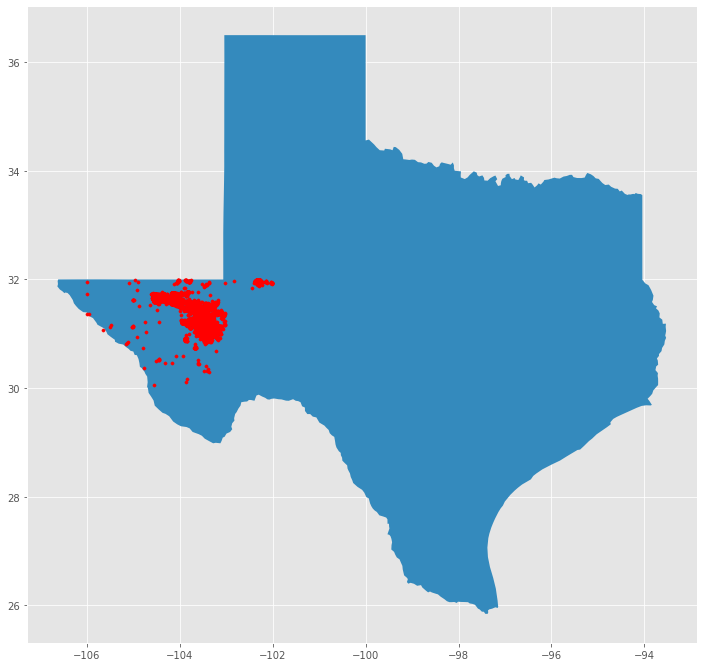

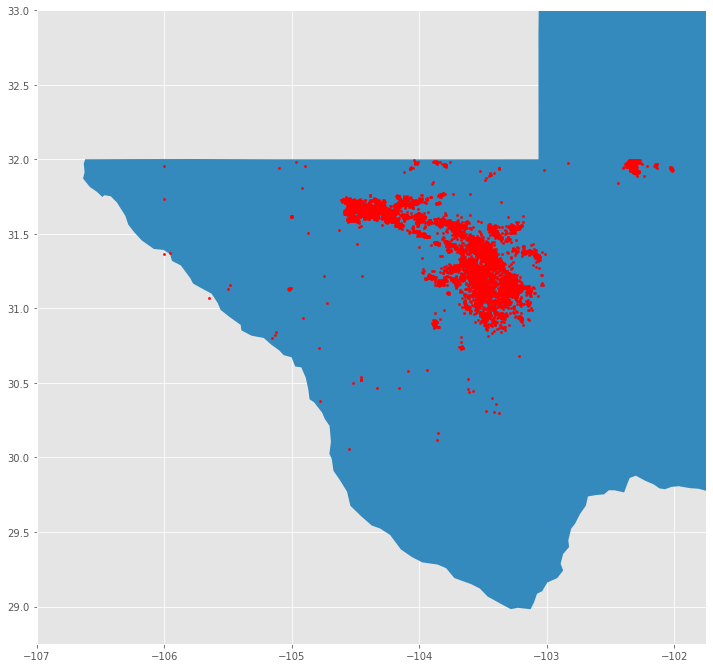

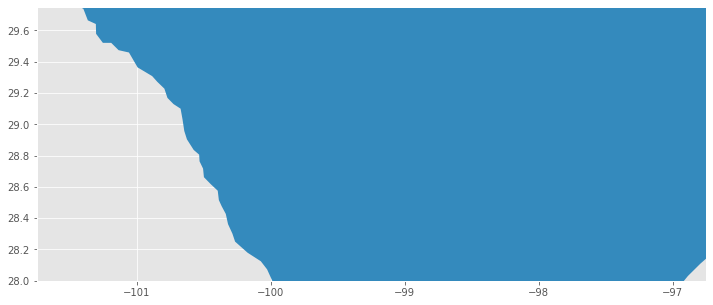

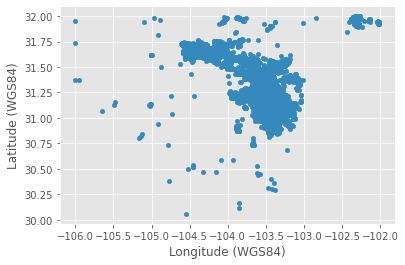

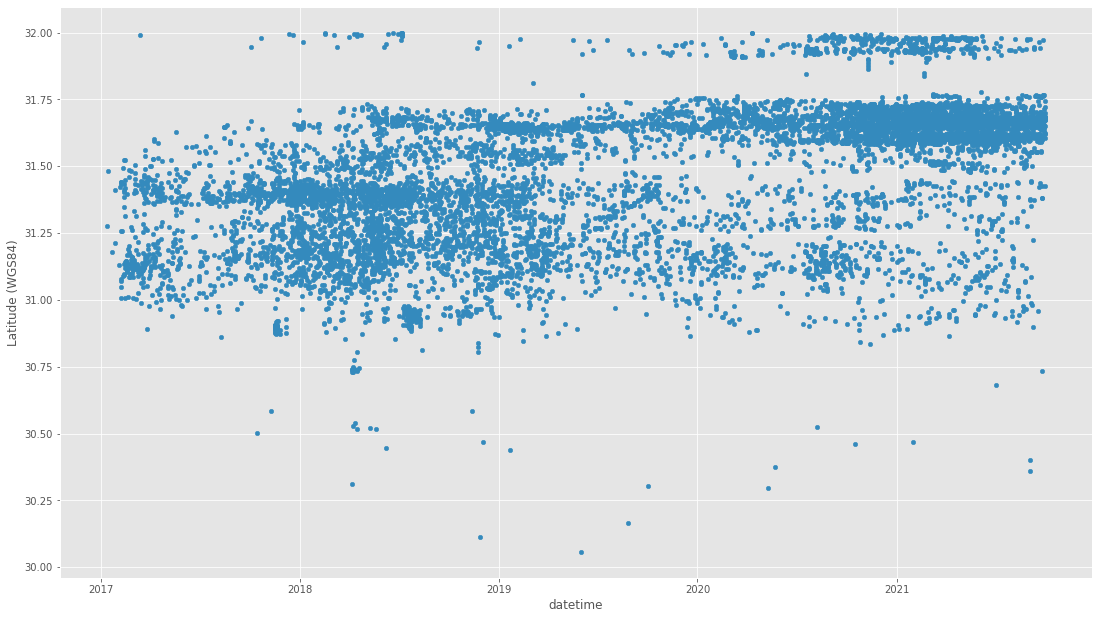

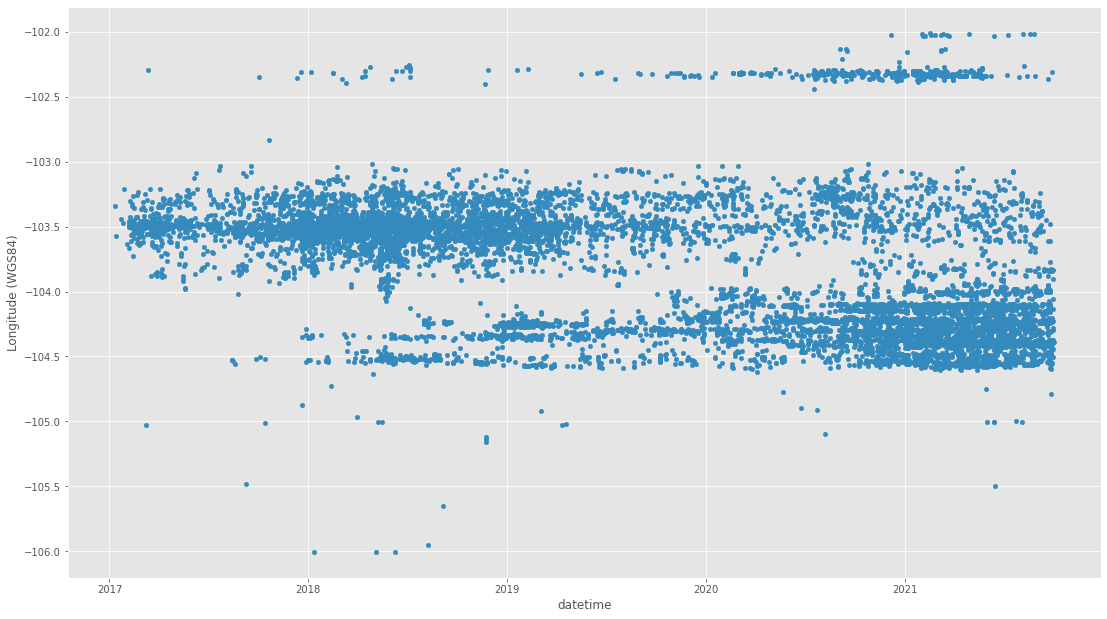

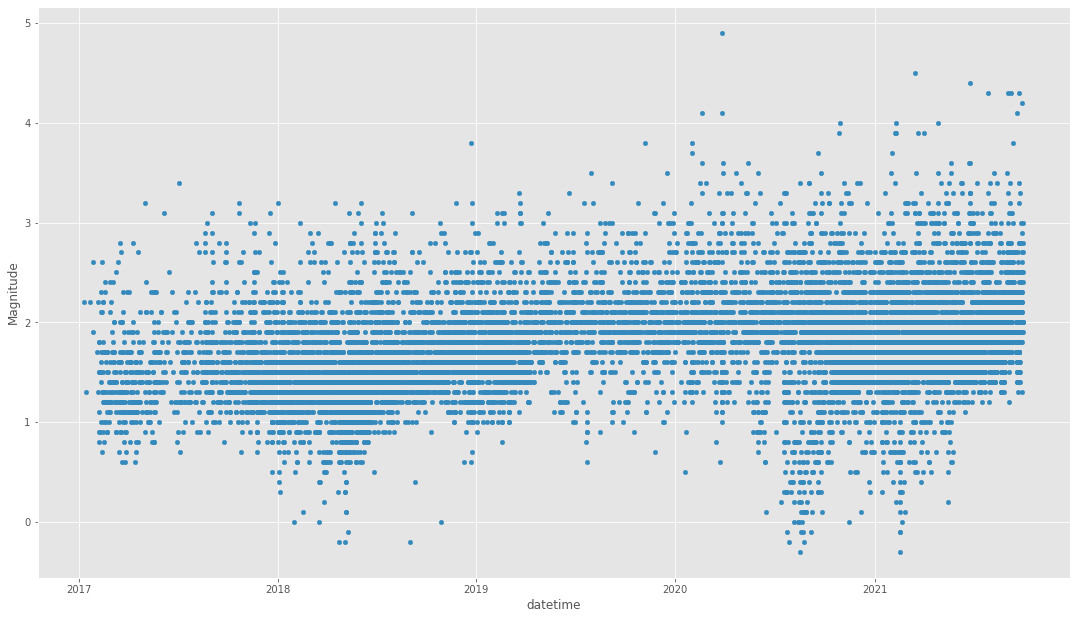

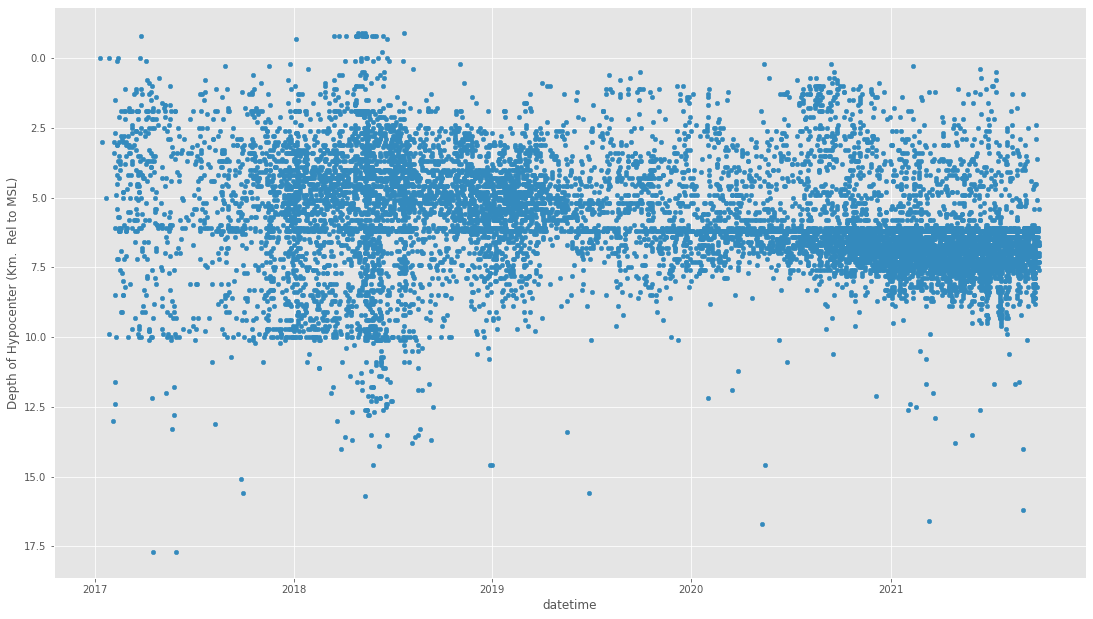

In [6]:
texas=states[states['NAME'] == 'Texas']                                             #any state could be named and plotted for data set of interest so long as US based
fig1=texas.plot(figsize=(12, 12))                                                   #full size state of TX
print(fig1.xaxis)
fig1.scatter(hypo_df["Longitude (WGS84)"],hypo_df["Latitude (WGS84)"],s=10,c="r")   #full size state of TX, plotting the events internally within figure

fig2=texas.plot(figsize=(12, 12))
print(fig2.xaxis)
fig2.scatter(hypo_df["Longitude (WGS84)"],hypo_df["Latitude (WGS84)"],s=5,c="r")   #zoomed on west segment of TX
fig2.set_xlim(-107,-101.75)
fig2.set_ylim(28.75,33)

fig3=texas.plot(figsize=(12, 12))
print(fig3.xaxis)
fig3.scatter(hypo_df["Longitude (WGS84)"],hypo_df["Latitude (WGS84)"],s=5,c="r")   #zoomed on south segment of TX
fig3.set_xlim(-101.75,-96.75)
fig3.set_ylim(28,29.75)
hypo_df.plot.scatter(x="Longitude (WGS84)", y="Latitude (WGS84)")

#fig.savefig('test2png.png', dpi=100)   #easy command to save and export image out from code

hypo_df.plot.scatter(x="datetime", y="Latitude (WGS84)")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

hypo_df.plot.scatter(x="datetime", y="Longitude (WGS84)")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

hypo_df.plot.scatter(x="datetime", y="Magnitude")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

hypo_df.plot.scatter(x="datetime", y="Depth of Hypocenter (Km.  Rel to MSL)")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.gca().invert_yaxis()


First use unsupervised learning to group/cluster the data in order to find tight linear trends and larger Mw activity

In [7]:
#insert Unsupervised learning
#first for the sake of just general interest lets try out Agglomerative Clustering...

In [8]:
def dendrogram_plotter(features, methods, metric):
    """Plots a dendrogram for the provided features for every method in methods using the provided metric
    
    Args:
        features (iterable): The features to use in creating the dendrogram
        methods (iterable): A list of strings where each one is a valid method to the linkage function
        metric (str): A metric for calculating the linkage
    """
    for method in methods:
        plt.figure(figsize = (100,100))                  #Change the figure size to your liking, going to stick with default
        Z=linkage(features,method=method,metric=metric) #Creating variable Z-ndarray via linkage- linkage matrix encoding the hierarchical clustering to render as a dendrogram. Linkage function for more information on the format of Z.
        dendrogram(Z)
        
        plt.title(f"{method.title()} Linkage Hypocenter Dataset Dendrogram")
        plt.show()

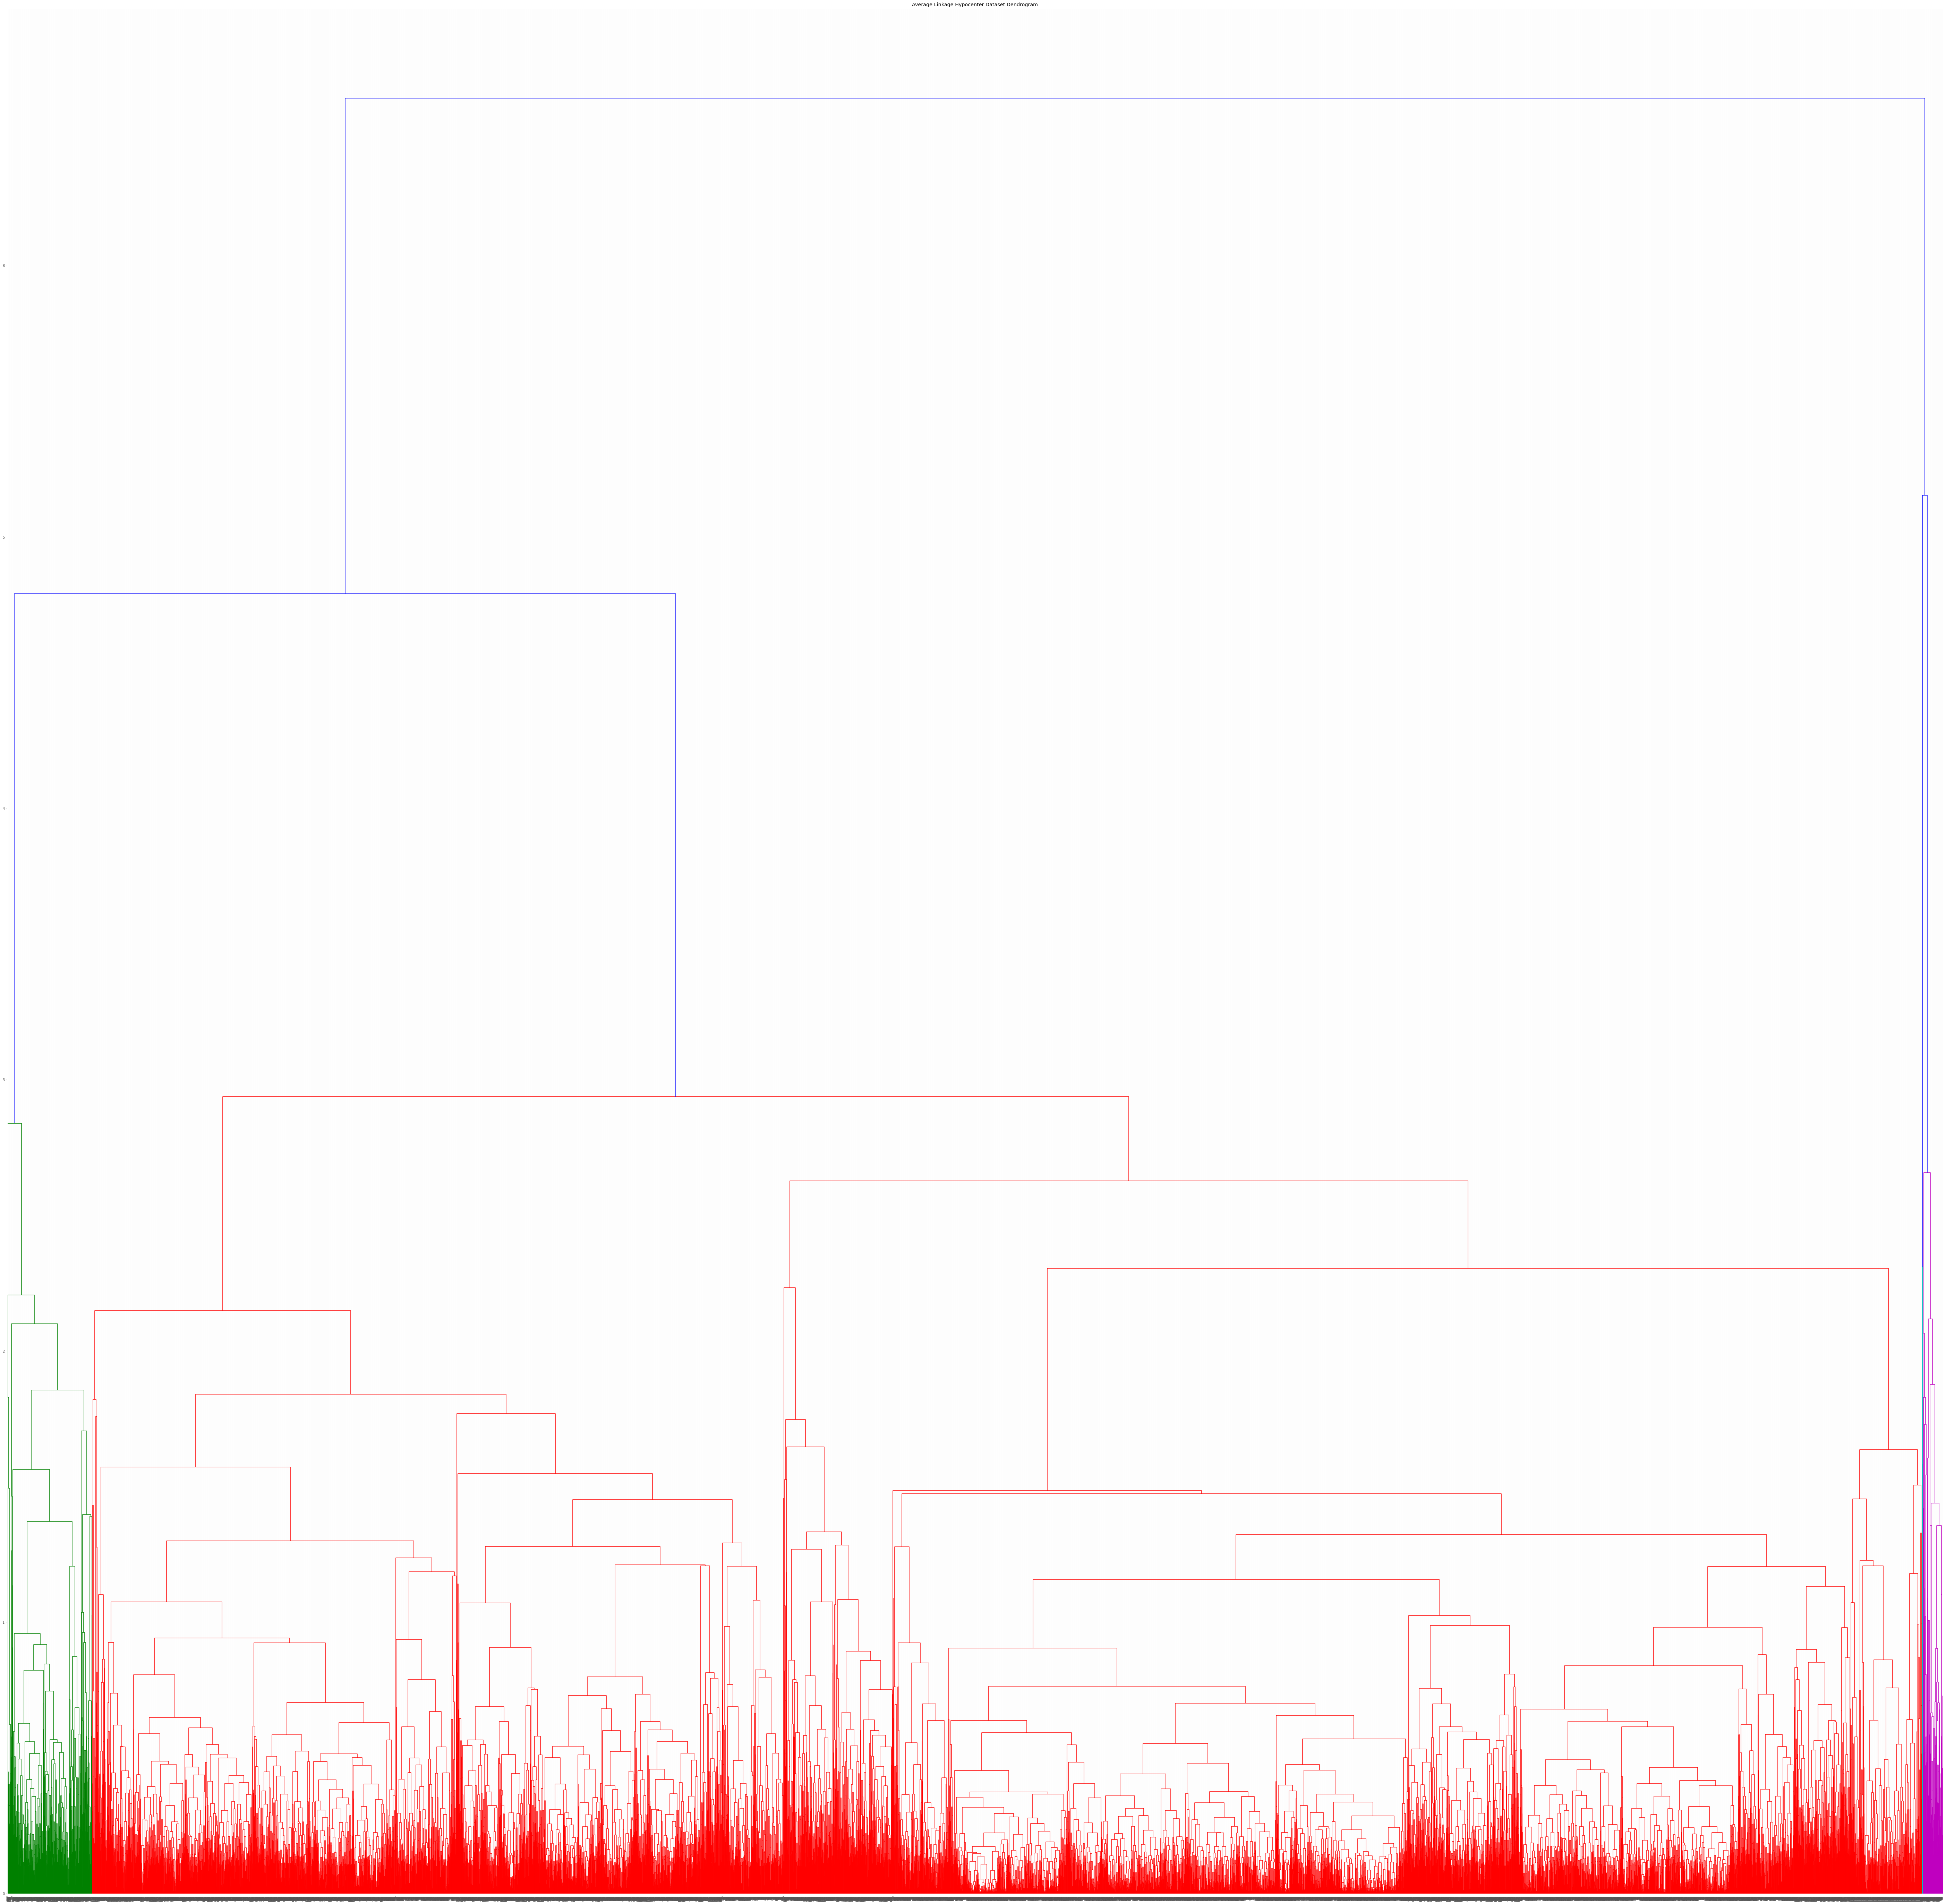

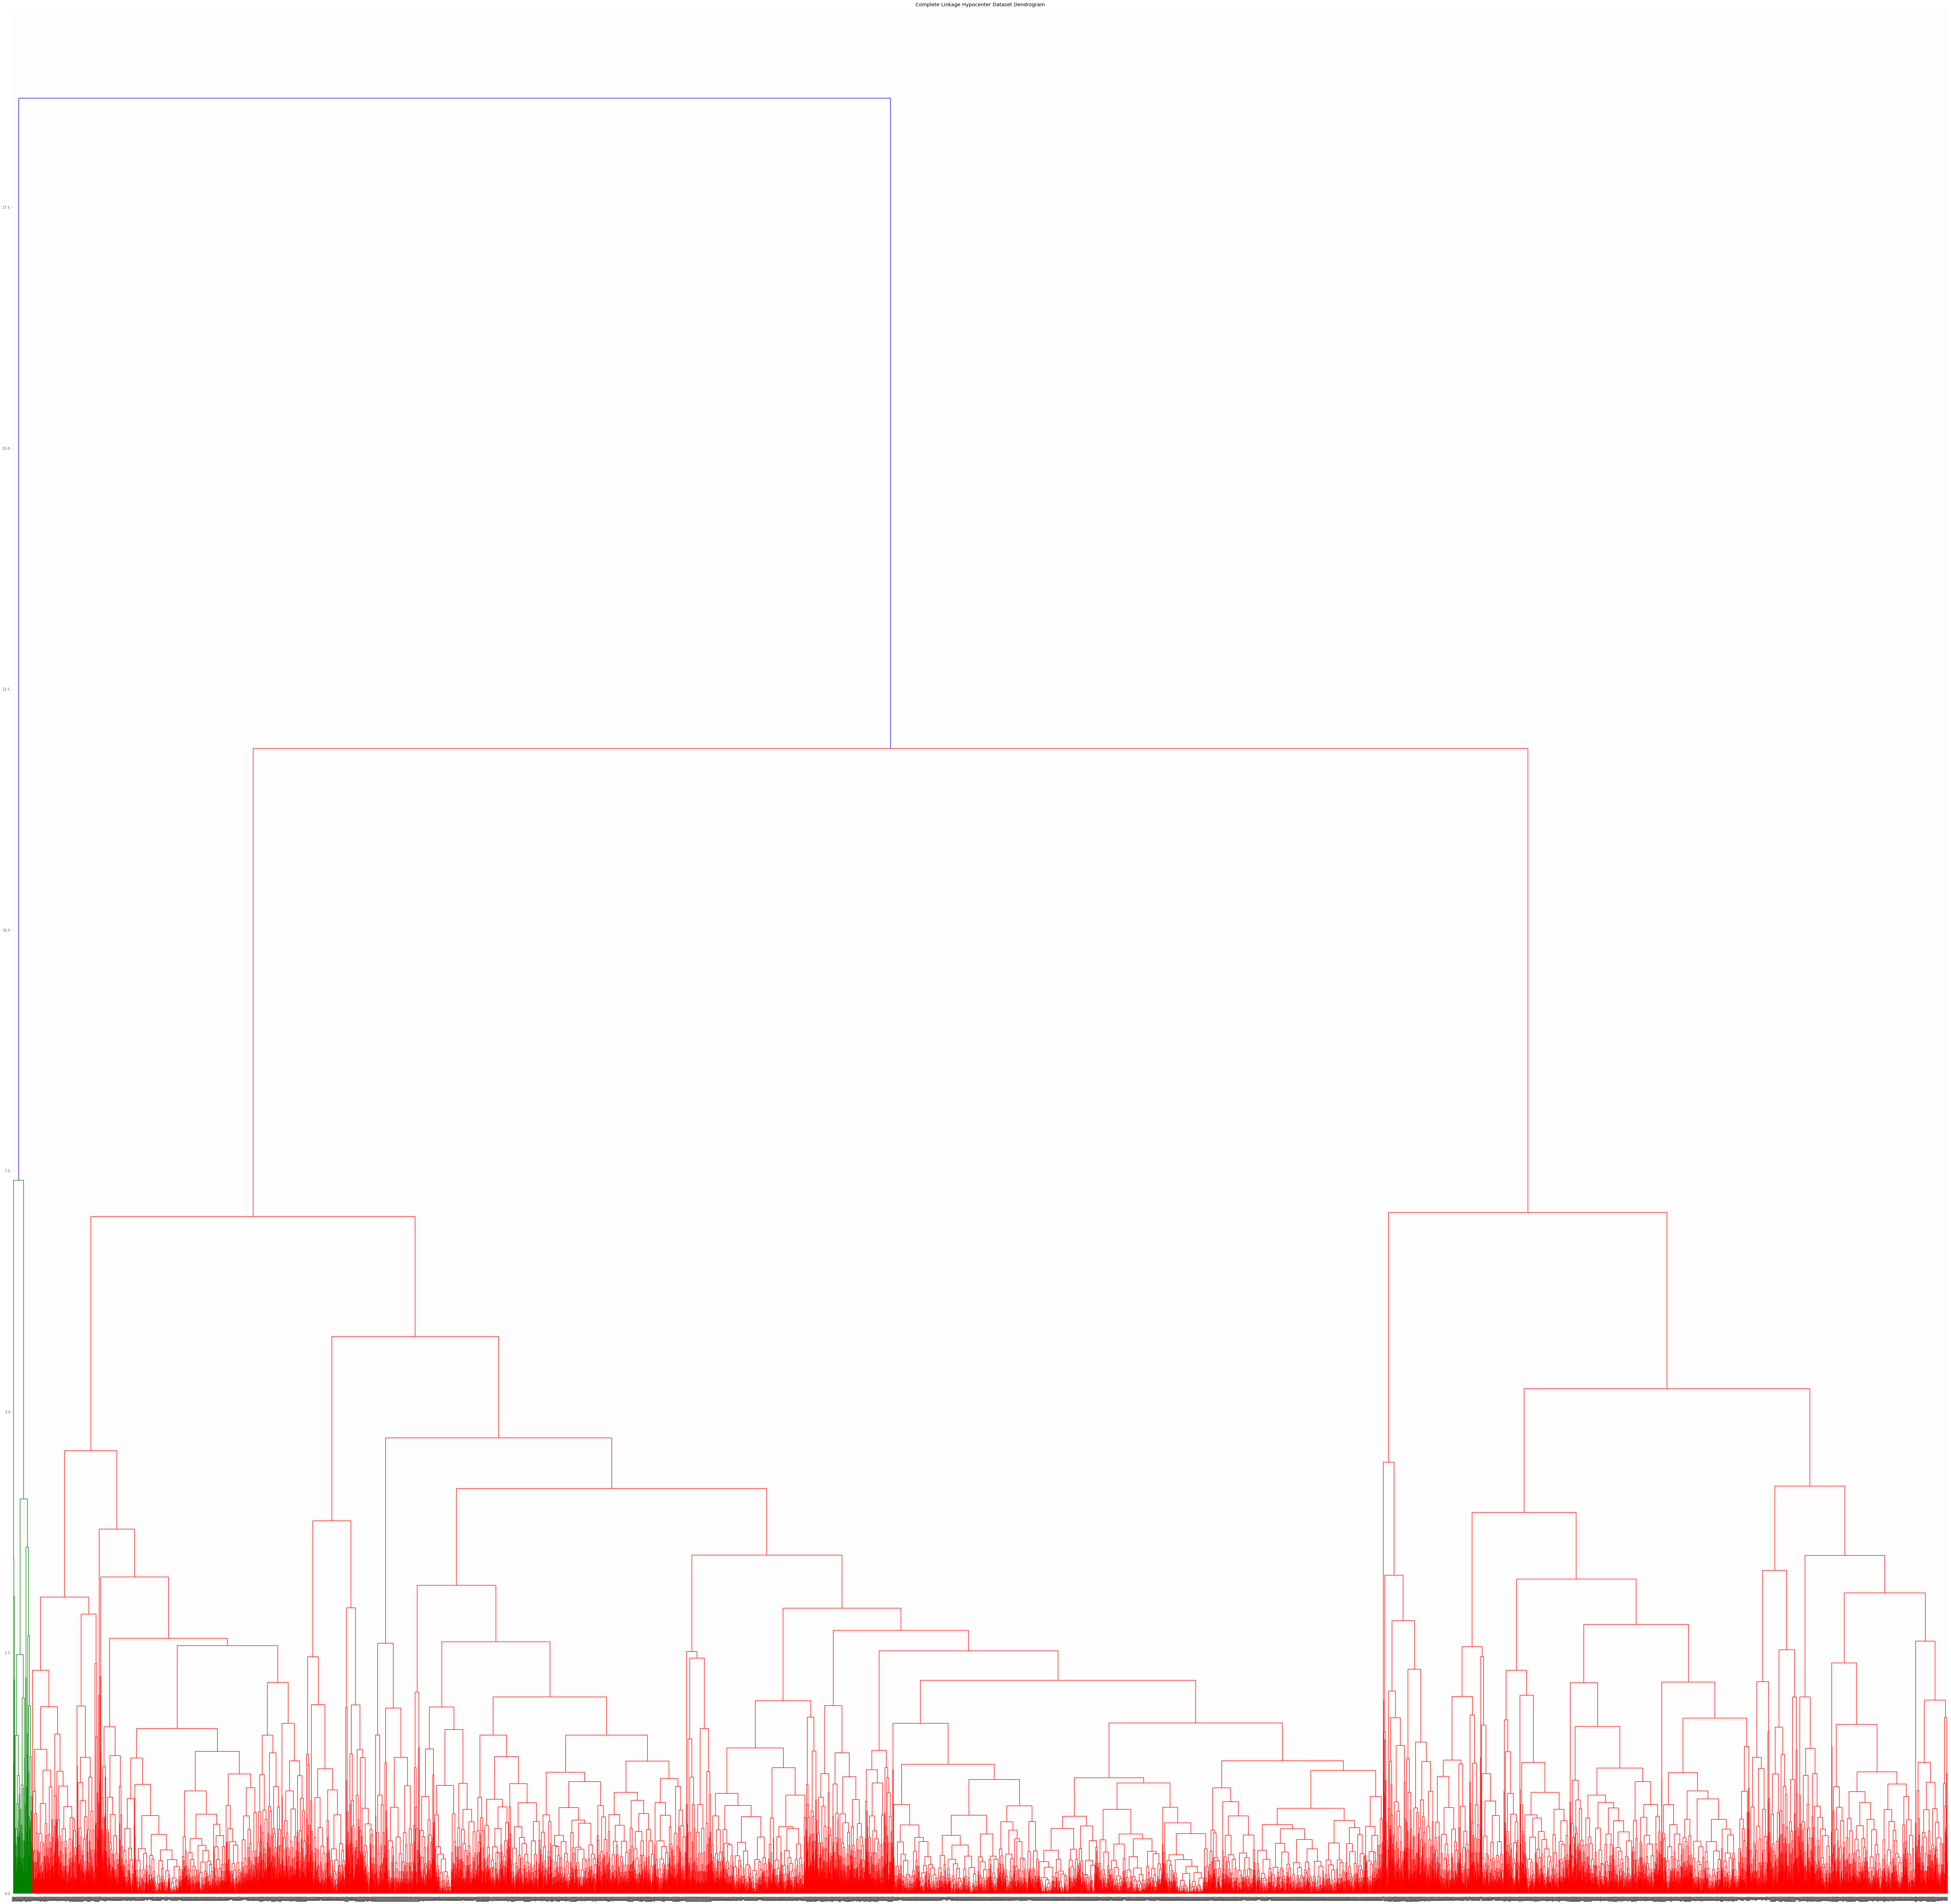

KeyboardInterrupt: ignored

In [17]:
hypo_features=hypo_df[["Latitude (WGS84)","Longitude (WGS84)","Depth of Hypocenter (Km.  Rel to MSL)","Magnitude"]]
#hypo_features.dtype[]
#print(hypo_features)
dendrogram_plotter(hypo_features,["average","complete","ward"],"euclidean")

Ok well Agglomerative is not very informative or helpful, likely due to this data type and quantity

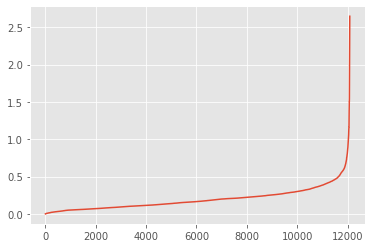

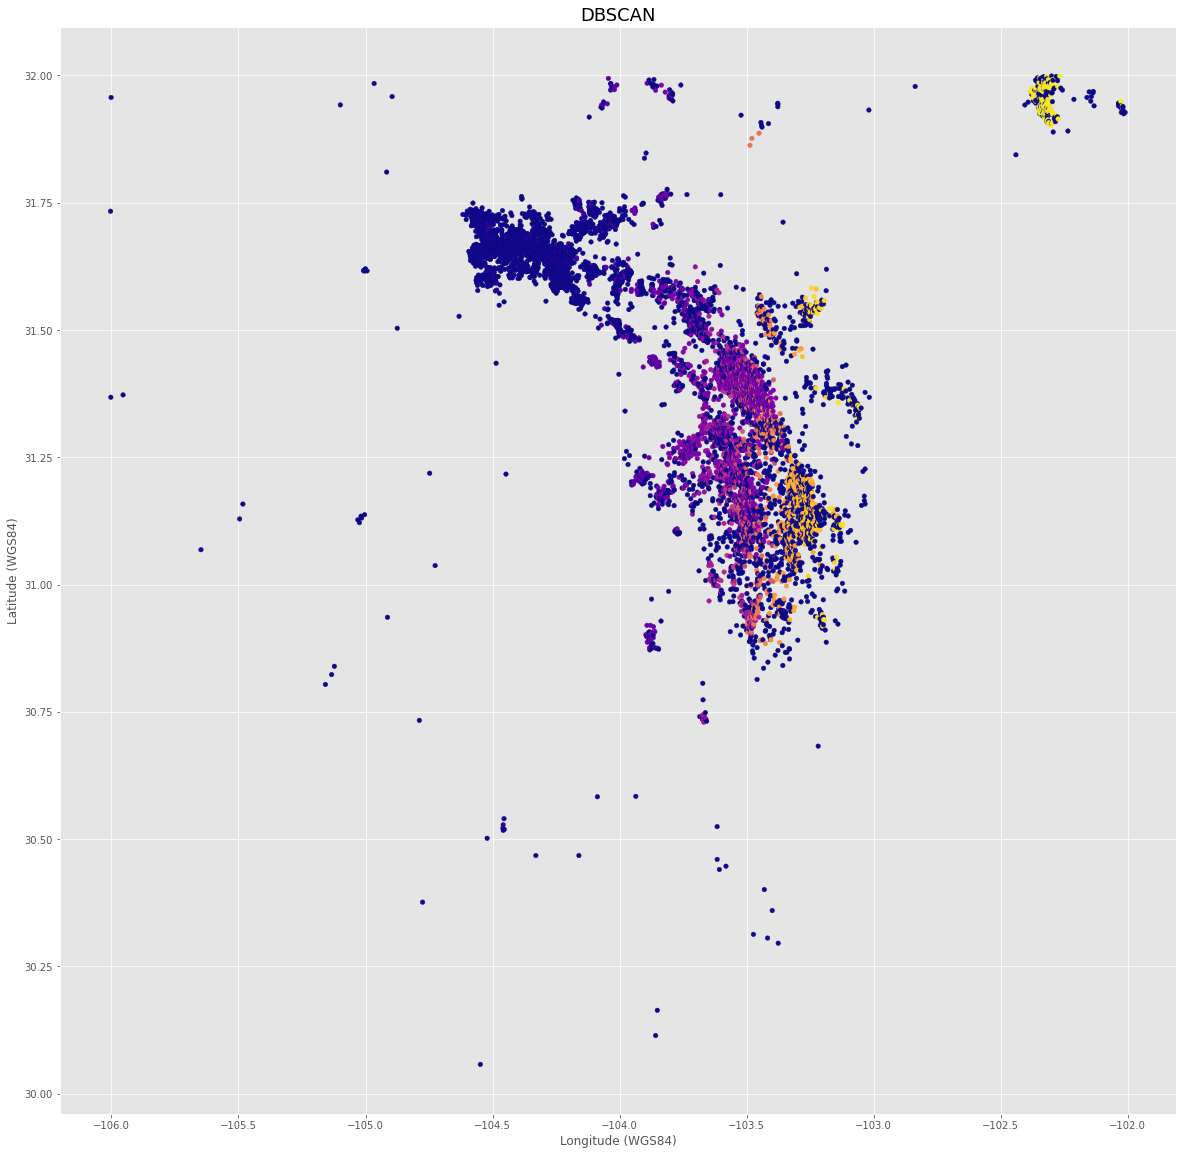

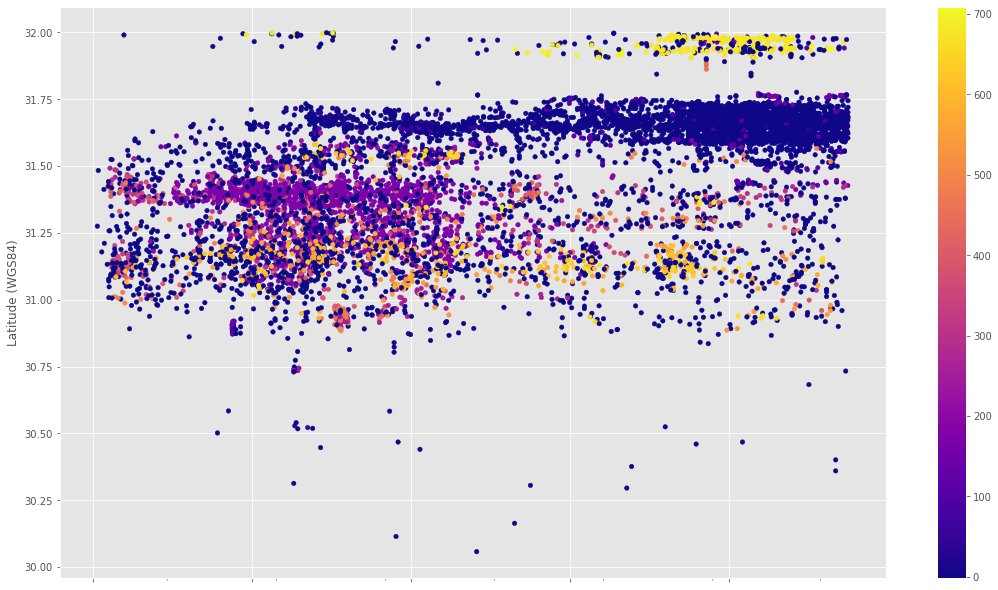

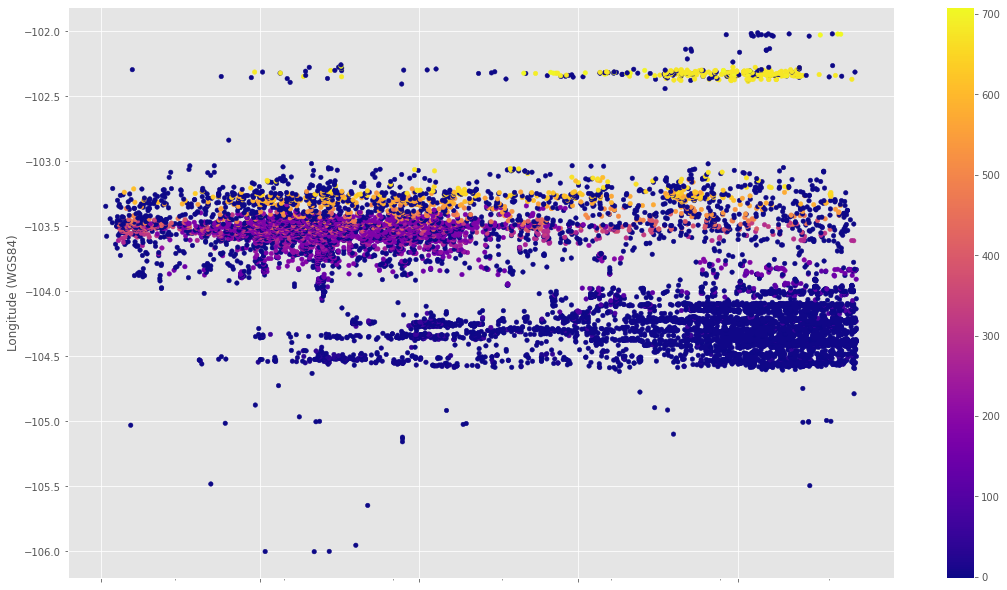

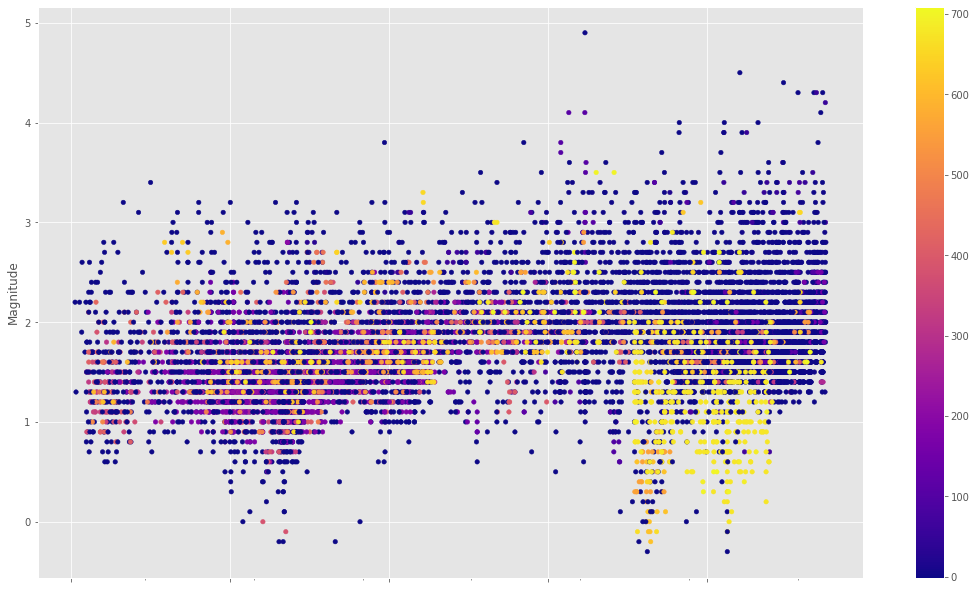

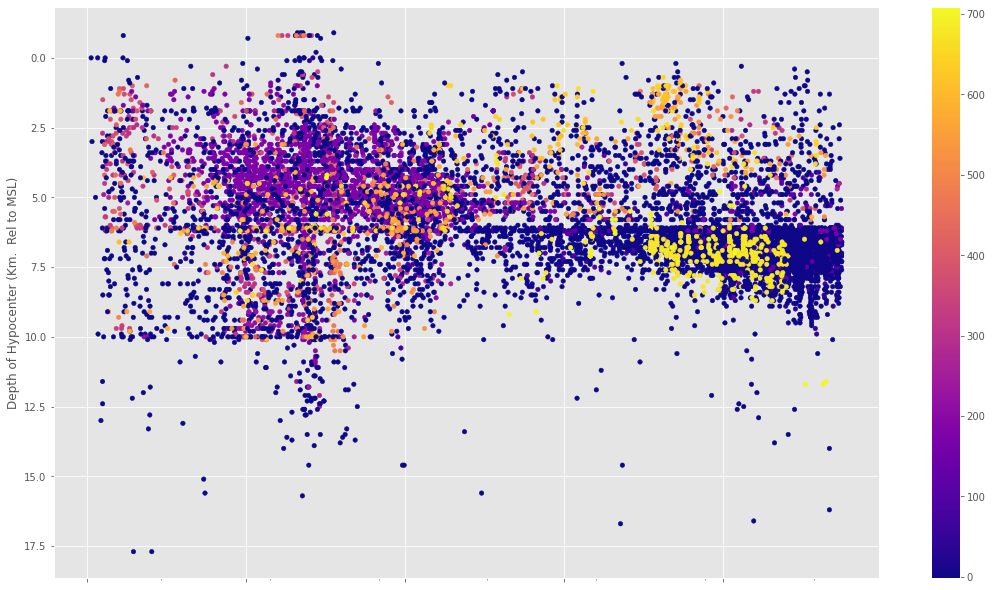

In [9]:
#then DBScan since that supposedly is low cost
hypo_features=hypo_df[["DateTime","Latitude (WGS84)","Longitude (WGS84)","Depth of Hypocenter (Km.  Rel to MSL)","Magnitude"]]
scaler=StandardScaler()
hypo_f_scaled=scaler.fit_transform(hypo_features)

#to determine the eps=value best for this data set... will it be best for other data hmmm maybe not...
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(hypo_f_scaled)
distances, indices = nbrs.kneighbors(hypo_f_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

dbsclustering=DBSCAN(eps=0.25, min_samples=2).fit_predict(hypo_f_scaled)
#print(dbsclustering)
plt.figure(figsize = (20,20))
plt.title("DBSCAN", size=18)
plt.scatter(hypo_df["Longitude (WGS84)"],hypo_df["Latitude (WGS84)"], s=20, c=dbsclustering, cmap="plasma")
plt.xlabel("Longitude (WGS84)")
plt.ylabel("Latitude (WGS84)")

hypo_df.plot.scatter(x="datetime", y="Latitude (WGS84)",s=20, c=dbsclustering, cmap="plasma")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

hypo_df.plot.scatter(x="datetime", y="Longitude (WGS84)",s=20, c=dbsclustering, cmap="plasma")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

hypo_df.plot.scatter(x="datetime", y="Magnitude",s=20, c=dbsclustering, cmap="plasma")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

hypo_df.plot.scatter(x="datetime", y="Depth of Hypocenter (Km.  Rel to MSL)",s=20, c=dbsclustering, cmap="plasma")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.gca().invert_yaxis()

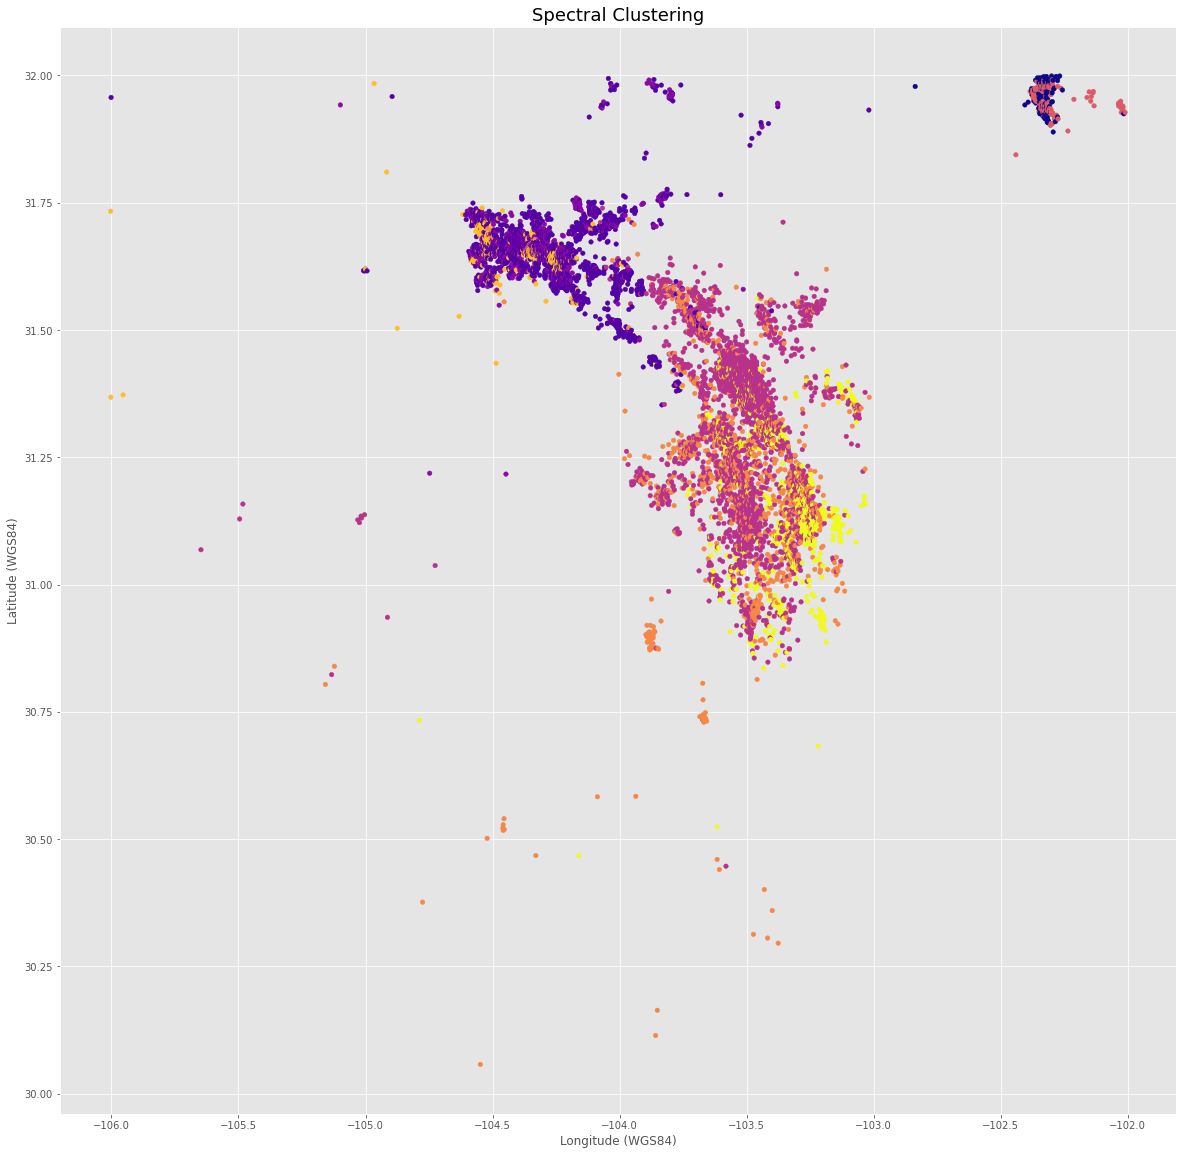

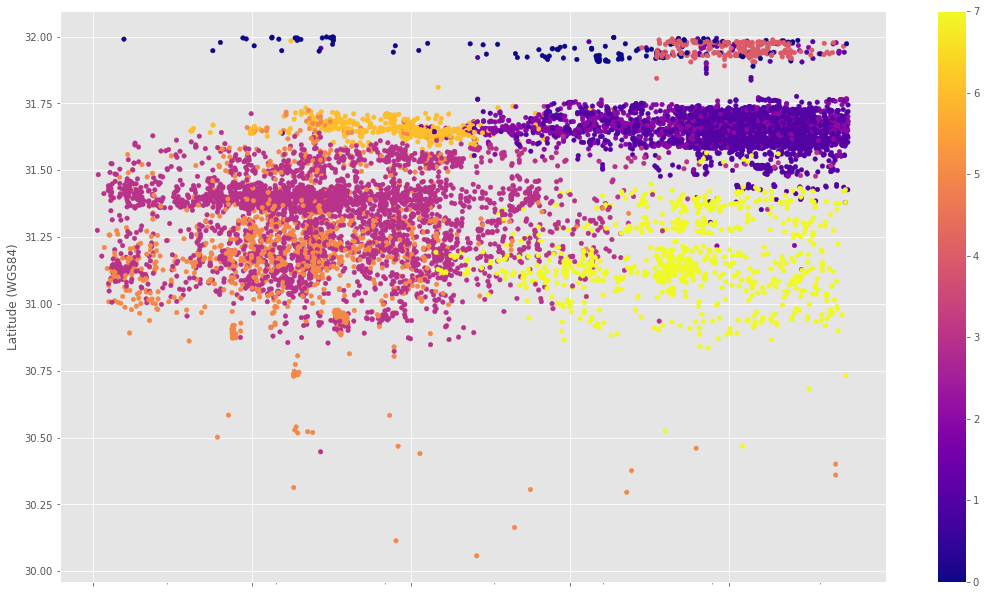

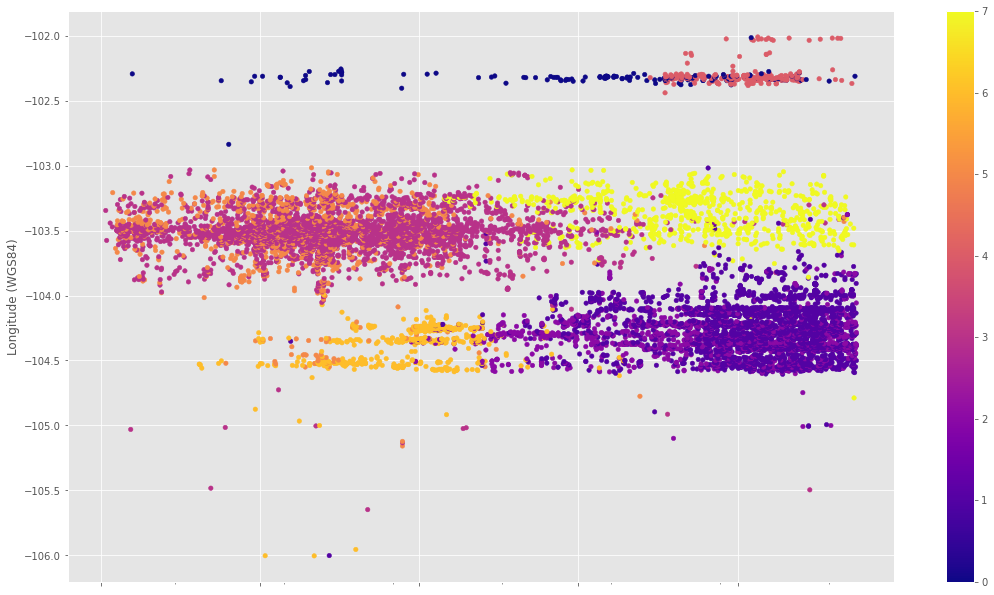

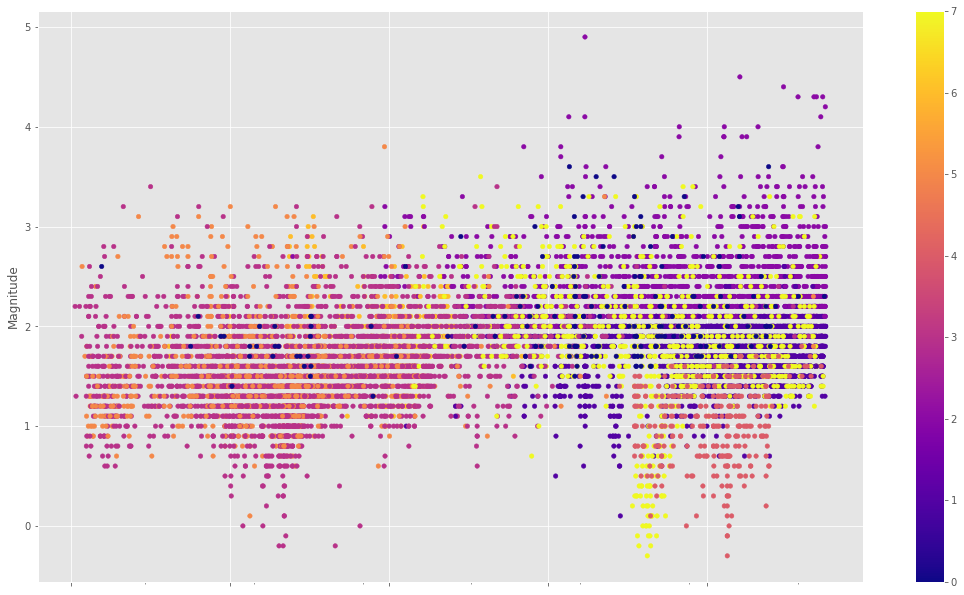

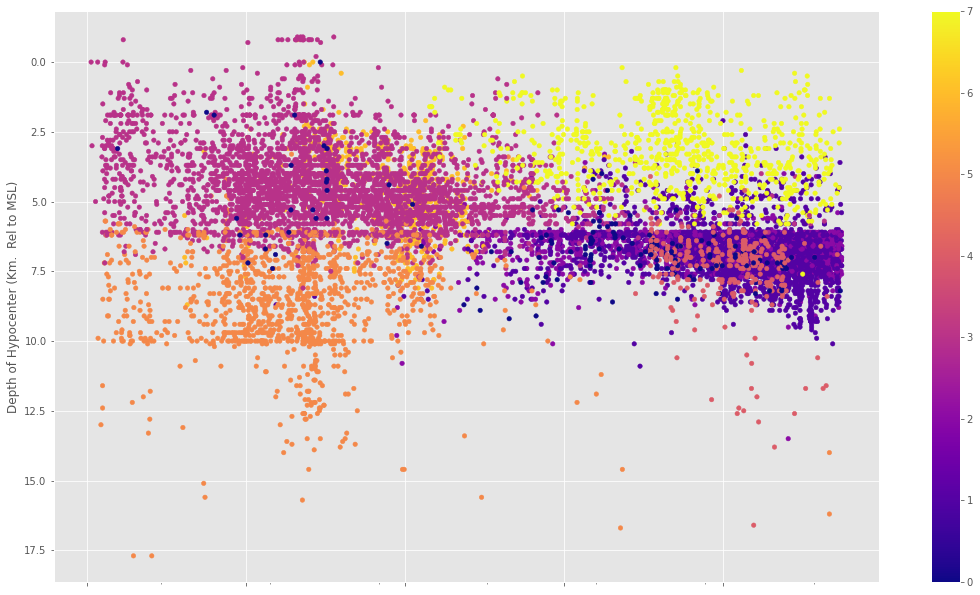

In [30]:
# Finally spectral clustering classifier saved as `clf`, using n_clusters=8. This is not truely ideal, I would prefer the coding and algorithm to figure what would be best for cluster count
# Fitting clf to the WTX hypocenter data
# Predict values for the WTX hypocenter data using clf and save them as spectral_pred
hypo_features=hypo_df[["DateTime","Latitude (WGS84)","Longitude (WGS84)","Depth of Hypocenter (Km.  Rel to MSL)","Magnitude"]]
scaler=StandardScaler()
hypo_f_scaled=scaler.fit_transform(hypo_features)

n_clusters=8
clf=SpectralClustering(n_clusters,eigen_solver='amg',affinity='nearest_neighbors')
spectralclustering=clf.fit_predict(hypo_f_scaled)
#print(spectralclustering)
hypo_df['SpectralClustering']=''                                         #a column to align a spectral clustering value/assignment per event
hypo_df['SpectralClustering']=spectralclustering                         #column is filled in

plt.figure(figsize = (20,20))
plt.title("Spectral Clustering", size=18)
plt.scatter(hypo_df["Longitude (WGS84)"],hypo_df["Latitude (WGS84)"], s=20, c=spectralclustering, cmap="plasma")
plt.xlabel("Longitude (WGS84)")
plt.ylabel("Latitude (WGS84)")


hypo_df.plot.scatter(x="datetime", y="Latitude (WGS84)",s=20, c=spectralclustering, cmap="plasma")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

hypo_df.plot.scatter(x="datetime", y="Longitude (WGS84)",s=20, c=spectralclustering, cmap="plasma")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

hypo_df.plot.scatter(x="datetime", y="Magnitude",s=20, c=spectralclustering, cmap="plasma")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

hypo_df.plot.scatter(x="datetime", y="Depth of Hypocenter (Km.  Rel to MSL)",s=20, c=spectralclustering, cmap="plasma")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.gca().invert_yaxis()

In [31]:
hypo_df.head()  #now it should show the new column of spectral values per event

EventID Evaluation Status  ...      DateTime SpectralClustering
0  texnet2018isgb             final  ...  1.525463e+09                  6
1  texnet2018auok             final  ...  1.515737e+09                  6
2  texnet2018ldie             final  ...  1.528446e+09                  1
3  texnet2018pktb       preliminary  ...  1.533715e+09                  6
4  texnet2018riqg             final  ...  1.536075e+09                  3

[5 rows x 33 columns]

Secondly, use the clustered data set and run it through a supervised learning- simple vector machine, to determine the hyperplane

0
              EventID Evaluation Status  ...      DateTime SpectralClustering
11582  texnet2017uotu             final  ...  1.508517e+09                  0
11584  texnet2018wvcx             final  ...  1.542813e+09                  0
11585  texnet2018evft             final  ...  1.520686e+09                  0
11587  texnet2020yrhy             final  ...  1.608164e+09                  0
11588  texnet2020qold             final  ...  1.598192e+09                  0
...               ...               ...  ...           ...                ...
12057  texnet2018hxnt             final  ...  1.524484e+09                  0
12058  texnet2018mqmi             final  ...  1.530298e+09                  0
12060  texnet2018navk             final  ...  1.530788e+09                  0
12062  texnet2018namu             final  ...  1.530772e+09                  0
12087  texnet2021cejb             final  ...  1.612124e+09                  0

[171 rows x 33 columns]
Equation:z = 454.77 + 1.62x + -8.85y


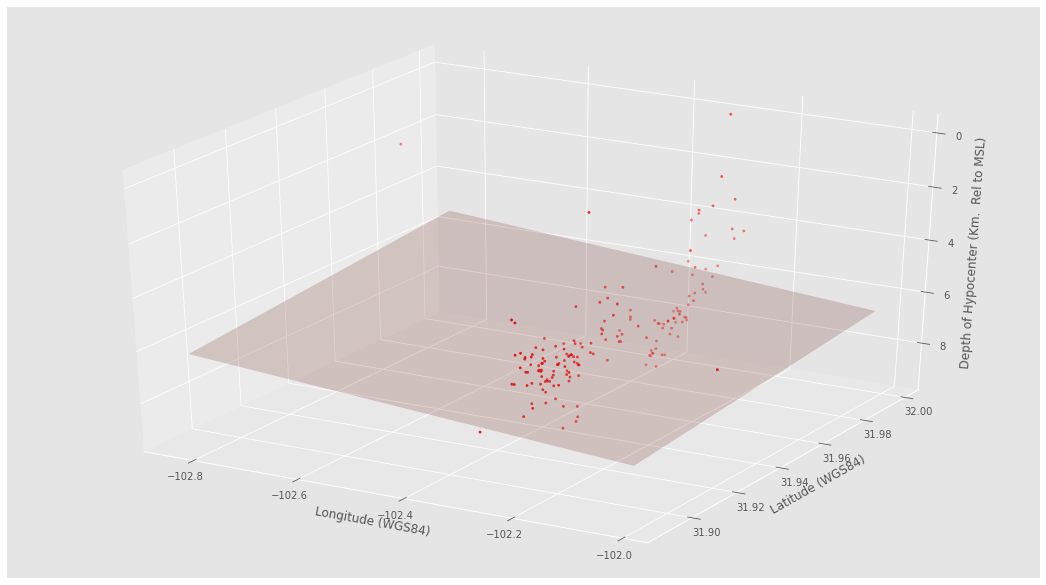

1
              EventID Evaluation Status  ...      DateTime SpectralClustering
2      texnet2018ldie             final  ...  1.528446e+09                  1
16     texnet2021llfr             final  ...  1.623514e+09                  1
18     texnet2021llfw             final  ...  1.623515e+09                  1
21     texnet2021oiig             final  ...  1.627066e+09                  1
25     texnet2020mifq             final  ...  1.592980e+09                  1
...               ...               ...  ...           ...                ...
10055  texnet2021lsnp             final  ...  1.623860e+09                  1
10173  texnet2021rbbk             final  ...  1.630411e+09                  1
10296  texnet2021rsgk             final  ...  1.631224e+09                  1
10297  texnet2021rrkt             final  ...  1.631185e+09                  1
11580  texnet2020uyki             final  ...  1.603581e+09                  1

[3565 rows x 33 columns]
Equation:z = -49.66 + -0.24x + 1.01y

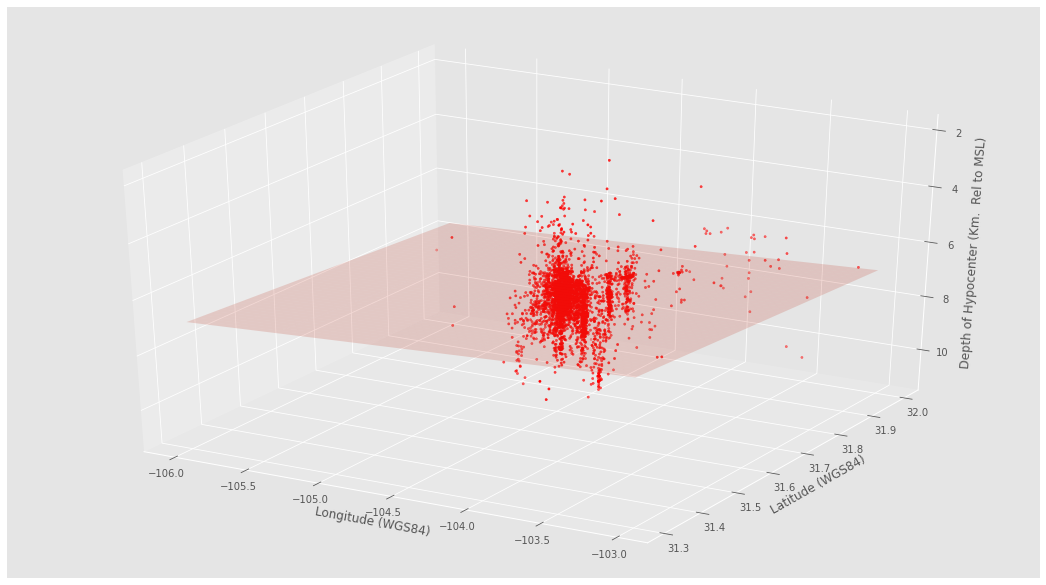

2
              EventID Evaluation Status  ...      DateTime SpectralClustering
10     texnet2020pjhl             final  ...  1.596719e+09                  2
15     texnet2021knlv             final  ...  1.622391e+09                  2
19     texnet2021papw             final  ...  1.627931e+09                  2
29     texnet2021kmyi             final  ...  1.622366e+09                  2
35     texnet2021jhfd             final  ...  1.620865e+09                  2
...               ...               ...  ...           ...                ...
6186   texnet2020veod             final  ...  1.603872e+09                  2
6567   texnet2021qsqg             final  ...  1.630012e+09                  2
8412   texnet2020czxr             final  ...  1.581521e+09                  2
9844   texnet2020vzre             final  ...  1.604870e+09                  2
10301  texnet2021rrso             final  ...  1.631199e+09                  2

[1665 rows x 33 columns]
Equation:z = 133.82 + 0.81x + -1.35y

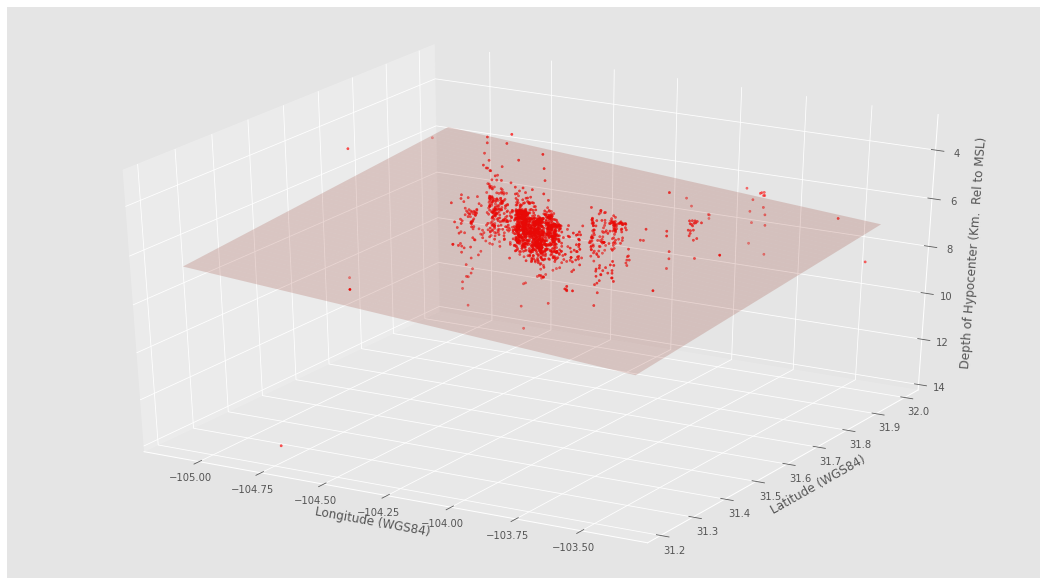

3
              EventID Evaluation Status  ...      DateTime SpectralClustering
4      texnet2018riqg             final  ...  1.536075e+09                  3
5      texnet2021lqdr             final  ...  1.623747e+09                  3
6      texnet2017rrpd             final  ...  1.504962e+09                  3
8      texnet2018wyse             final  ...  1.542982e+09                  3
11     texnet2017etqf             final  ...  1.489075e+09                  3
...               ...               ...  ...           ...                ...
11569  texnet2019qawd             final  ...  1.566014e+09                  3
11570  texnet2018lkzn             final  ...  1.528809e+09                  3
11571  texnet2019orou             final  ...  1.564345e+09                  3
11574  texnet2018drng             final  ...  1.519281e+09                  3
11577  texnet2017ohqx             final  ...  1.500804e+09                  3

[3594 rows x 33 columns]
Equation:z = 52.04 + 0.40x + -0.19y


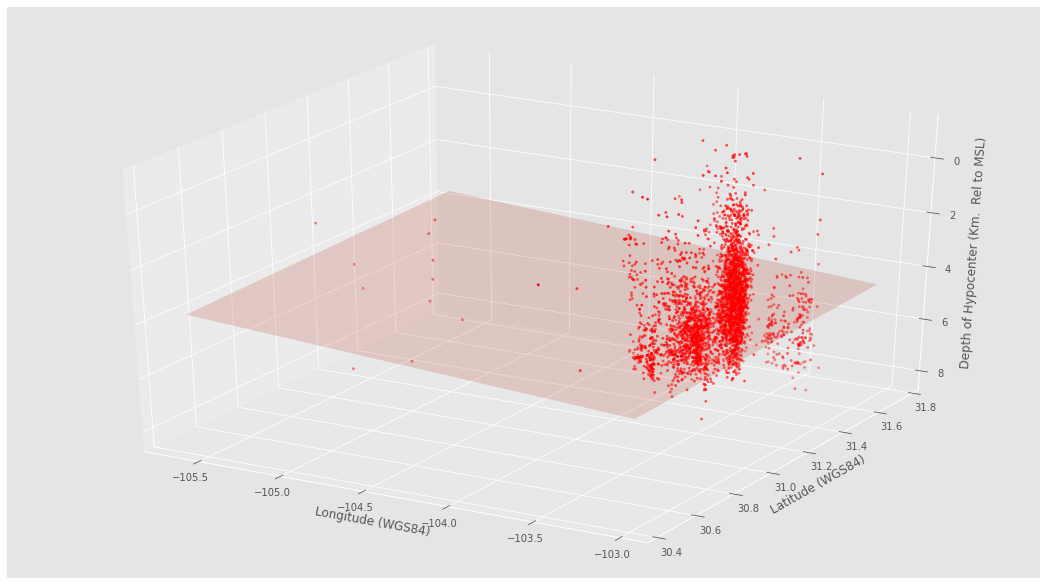

4
              EventID Evaluation Status  ...      DateTime SpectralClustering
11583  texnet2020nzvq       preliminary  ...  1.595042e+09                  4
11586  texnet2021brib             final  ...  1.611507e+09                  4
11590  texnet2020yriv             final  ...  1.608165e+09                  4
11591  texnet2020pkuq             final  ...  1.596790e+09                  4
11592  texnet2020wrsb             final  ...  1.605723e+09                  4
...               ...               ...  ...           ...                ...
12083  texnet2021qdhy             final  ...  1.629288e+09                  4
12084  texnet2021pgpr             final  ...  1.628214e+09                  4
12085  texnet2021ihlx             final  ...  1.619648e+09                  4
12086  texnet2021eyfn       preliminary  ...  1.615522e+09                  4
12088  texnet2021dfwf             final  ...  1.613425e+09                  4

[336 rows x 33 columns]
Equation:z = 1060.91 + 15.46x + 16.54

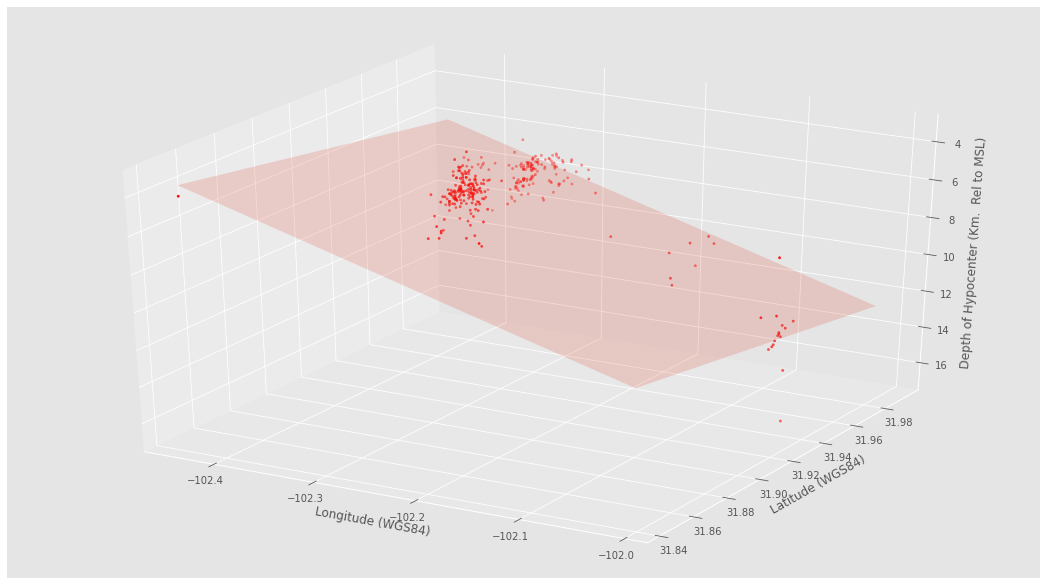

5
              EventID Evaluation Status  ...      DateTime SpectralClustering
7      texnet2018wyic             final  ...  1.542964e+09                  5
9      texnet2018wyjw             final  ...  1.542967e+09                  5
28     texnet2020jyom             final  ...  1.590064e+09                  5
299    texnet2018hgtj       preliminary  ...  1.523690e+09                  5
329    texnet2018ldza       preliminary  ...  1.528477e+09                  5
...               ...               ...  ...           ...                ...
11558  texnet2018mlbm             final  ...  1.530042e+09                  5
11568  texnet2018lafv             final  ...  1.528300e+09                  5
11572  texnet2018kzsm       preliminary  ...  1.528276e+09                  5
11578  texnet2017sgel             final  ...  1.505652e+09                  5
11581  texnet2018ihad             final  ...  1.524932e+09                  5

[1272 rows x 33 columns]
Equation:z = -112.90 + -0.32x + 2.83

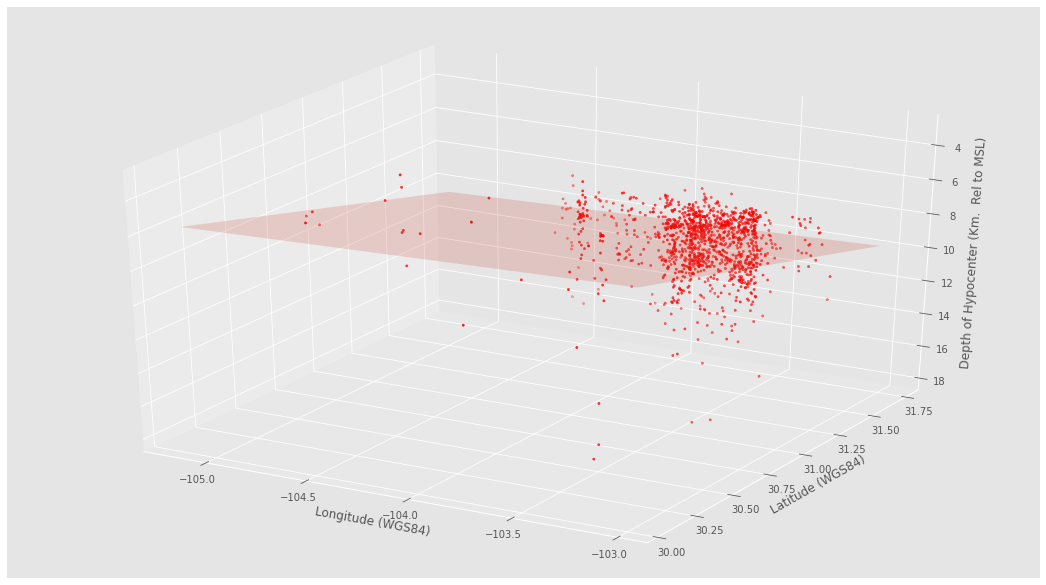

6
             EventID Evaluation Status  ...      DateTime SpectralClustering
0     texnet2018isgb             final  ...  1.525463e+09                  6
1     texnet2018auok             final  ...  1.515737e+09                  6
3     texnet2018pktb       preliminary  ...  1.533715e+09                  6
20    texnet2018jotz             final  ...  1.526529e+09                  6
22    texnet2018ghwv             final  ...  1.522514e+09                  6
...              ...               ...  ...           ...                ...
4927  texnet2019bcwe       preliminary  ...  1.547665e+09                  6
5082  texnet2019vmse       preliminary  ...  1.572721e+09                  6
5315  texnet2018jznn       preliminary  ...  1.527037e+09                  6
5649  texnet2018kftx             final  ...  1.527333e+09                  6
5675  texnet2018kexa             final  ...  1.527291e+09                  6

[668 rows x 33 columns]
Equation:z = 464.63 + 3.77x + -2.10y


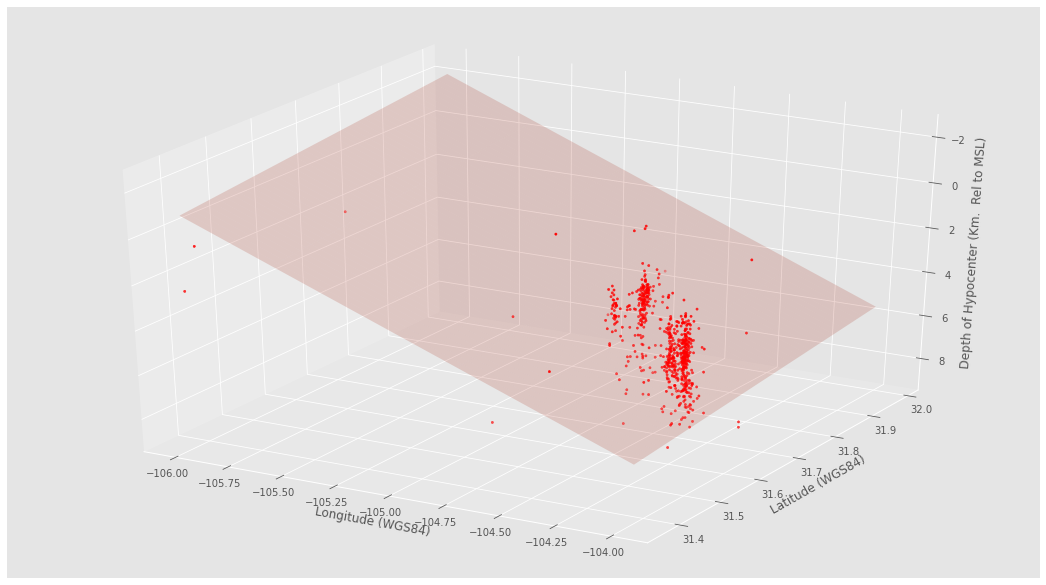

7
              EventID Evaluation Status  ...      DateTime SpectralClustering
27     texnet2021stua             final  ...  1.632526e+09                  7
4555   texnet2021cday             final  ...  1.612062e+09                  7
5985   texnet2021lkjm             final  ...  1.623474e+09                  7
6281   texnet2021fxqf             final  ...  1.616724e+09                  7
6357   texnet2020yxzk             final  ...  1.608479e+09                  7
...               ...               ...  ...           ...                ...
11566  texnet2020sukm             final  ...  1.600933e+09                  7
11573  texnet2021hjss             final  ...  1.618526e+09                  7
11575  texnet2020ecir             final  ...  1.582865e+09                  7
11576  texnet2020cbgs             final  ...  1.580355e+09                  7
11579  texnet2019yrcb             final  ...  1.576617e+09                  7

[818 rows x 33 columns]
Equation:z = -109.49 + -1.48x + -1.29

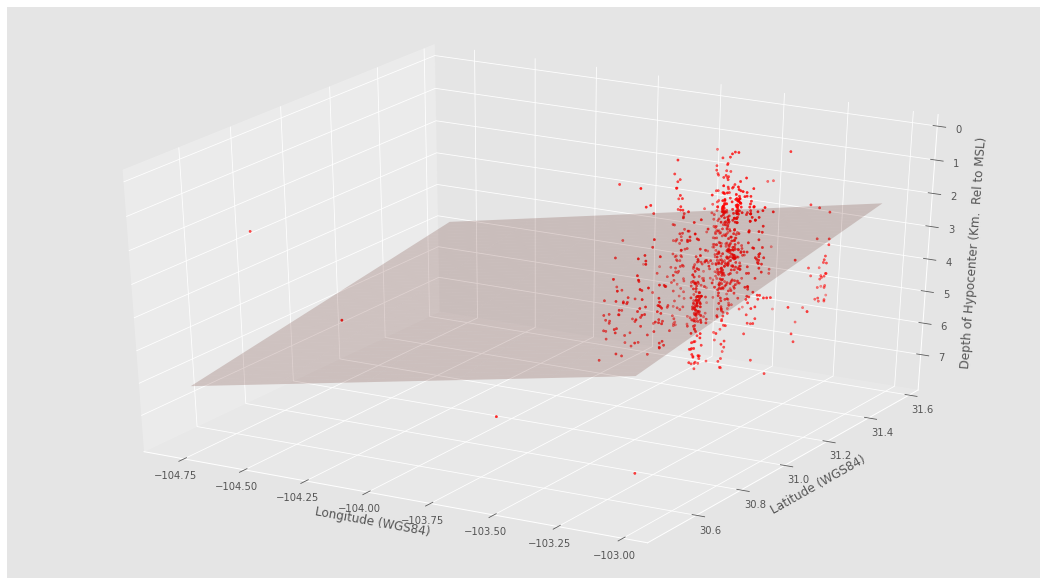

In [32]:
#insert supervised learning: Linear Regression of spectral clustering groups
#good link to think over filtering based on value in one column to create new sub-df
spectralcountLinR=0
for spectralcountLinR in range (n_clusters):                            #Tied to same cluster count as the spectral clustering cell, so that must be run first & in theory different values could be used
    IndexLinR=hypo_df[hypo_df['SpectralClustering']==spectralcountLinR]
    print(spectralcountLinR)
    print(IndexLinR)

    fig = plt.figure(figsize=plt.figaspect(1)*3)
    ax = plt.axes(projection='3d')
    ax.scatter(IndexLinR["Longitude (WGS84)"],IndexLinR["Latitude (WGS84)"],IndexLinR["Depth of Hypocenter (Km.  Rel to MSL)"], marker='.', color='red')
    ax.set_xlabel("Longitude (WGS84)")
    ax.set_ylabel("Latitude (WGS84)")
    ax.set_zlabel("Depth of Hypocenter (Km.  Rel to MSL)")
    fig.set_size_inches(18.5, 10.5)

    modelLinR=sklearn.linear_model.LinearRegression()
    X=IndexLinR[["Longitude (WGS84)","Latitude (WGS84)"]]
    Y=IndexLinR["Depth of Hypocenter (Km.  Rel to MSL)"] 
    modelLinR.fit(X,Y)
    Z_pred=modelLinR.predict(X)
    #print(Z_pred)

    coefs = modelLinR.coef_
    intercept = modelLinR.intercept_
    x_range=np.linspace(IndexLinR["Longitude (WGS84)"].min(), IndexLinR["Longitude (WGS84)"].max(),num=50, endpoint=True)
    y_range=np.linspace(IndexLinR["Latitude (WGS84)"].min(), IndexLinR["Latitude (WGS84)"].max(),num=50, endpoint=True)
    #print(IndexLinR["Longitude (WGS84)"].min())
    #print(IndexLinR["Longitude (WGS84)"].max())
    #print(IndexLinR["Latitude (WGS84)"].min())
    #print(IndexLinR["Latitude (WGS84)"].max())

    X,Y=np.meshgrid(x_range,y_range)
    #print(X)
    #print(Y)

    Z=X*coefs[0]+Y*coefs[1]+intercept
    #print(Z)
    print("Equation:z = {:.2f} + {:.2f}x + {:.2f}y".format(intercept,coefs[0],coefs[1]))

    ax.plot_surface(X, Y, Z, rstride=1, cstride=10, alpha = 0.2)
    #plt.xlim([min(hypo_df["Longitude (WGS84)"]), max(hypo_df["Longitude (WGS84)"])])
    #plt.ylim([min(hypo_df["Latitude (WGS84)"]), max(hypo_df["Latitude (WGS84)"])])
    #ax.set_zlim([min(hypo_df["Depth of Hypocenter (Km.  Rel to MSL)"]), max(hypo_df["Depth of Hypocenter (Km.  Rel to MSL)"])])
    ax.invert_zaxis()
    plt.show()
    spectralcountLinR+=1

In [33]:
#insert supervised learning: 3D regression surface with px.scatter_3d and go.Surface
#https://plotly.com/python/ml-regression/
spectralcount3DregGo=0
for spectralcount3DregGo in range (n_clusters):                                 #Tied to same cluster count as the spectral clustering cell, so that must be run first & in theory different values could be used
    Index3DregGo=hypo_df[hypo_df['SpectralClustering']==spectralcount3DregGo]
    print(spectralcount3DregGo)
    print(Index3DregGo)

    mesh_size = .02
    margin = 0

    # Condition the model
    modelSVR=SVR(C=1.)
    X=Index3DregGo[["Longitude (WGS84)","Latitude (WGS84)"]]
    Y=-Index3DregGo["Depth of Hypocenter (Km.  Rel to MSL)"]                           #Reversed axes are not supported in px.scatter_3D, so instead multipled depth by-1
    modelSVR.fit(X,Y)

    # Create a mesh grid on which we will run our model
    x_min,x_max=X["Longitude (WGS84)"].min()-margin,X["Longitude (WGS84)"].max()+margin
    y_min,y_max=X["Latitude (WGS84)"].min()-margin,X["Latitude (WGS84)"].max()+margin
    xrange=np.arange(x_min, x_max, mesh_size)
    yrange=np.arange(y_min, y_max, mesh_size)
    xx,yy=np.meshgrid(xrange, yrange)

    # Run model
    pred=modelSVR.predict(np.c_[xx.ravel(), yy.ravel()])
    pred=pred.reshape(xx.shape)
    #print(pred)

    fig=px.scatter_3d(Index3DregGo,x="Longitude (WGS84)",y="Latitude (WGS84)",z=-Index3DregGo["Depth of Hypocenter (Km.  Rel to MSL)"])  #Reversed axes are not supported in px.scatter_3D, so instead multipled depth by-1
    fig.update_layout(scene = dict(zaxis_title='Depth of Hypocenter (Km. Rel to MSL)'))
    fig.update_traces(marker=dict(size=3))
    fig.add_traces(go.Surface(x=xrange, y=yrange, z=pred, name='pred_surface', opacity=0.4))
    fig.show()
spectralcount3DregGo+=1

0
              EventID Evaluation Status  ...      DateTime SpectralClustering
11582  texnet2017uotu             final  ...  1.508517e+09                  0
11584  texnet2018wvcx             final  ...  1.542813e+09                  0
11585  texnet2018evft             final  ...  1.520686e+09                  0
11587  texnet2020yrhy             final  ...  1.608164e+09                  0
11588  texnet2020qold             final  ...  1.598192e+09                  0
...               ...               ...  ...           ...                ...
12057  texnet2018hxnt             final  ...  1.524484e+09                  0
12058  texnet2018mqmi             final  ...  1.530298e+09                  0
12060  texnet2018navk             final  ...  1.530788e+09                  0
12062  texnet2018namu             final  ...  1.530772e+09                  0
12087  texnet2021cejb             final  ...  1.612124e+09                  0

[171 rows x 33 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



1
              EventID Evaluation Status  ...      DateTime SpectralClustering
2      texnet2018ldie             final  ...  1.528446e+09                  1
16     texnet2021llfr             final  ...  1.623514e+09                  1
18     texnet2021llfw             final  ...  1.623515e+09                  1
21     texnet2021oiig             final  ...  1.627066e+09                  1
25     texnet2020mifq             final  ...  1.592980e+09                  1
...               ...               ...  ...           ...                ...
10055  texnet2021lsnp             final  ...  1.623860e+09                  1
10173  texnet2021rbbk             final  ...  1.630411e+09                  1
10296  texnet2021rsgk             final  ...  1.631224e+09                  1
10297  texnet2021rrkt             final  ...  1.631185e+09                  1
11580  texnet2020uyki             final  ...  1.603581e+09                  1

[3565 rows x 33 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



2
              EventID Evaluation Status  ...      DateTime SpectralClustering
10     texnet2020pjhl             final  ...  1.596719e+09                  2
15     texnet2021knlv             final  ...  1.622391e+09                  2
19     texnet2021papw             final  ...  1.627931e+09                  2
29     texnet2021kmyi             final  ...  1.622366e+09                  2
35     texnet2021jhfd             final  ...  1.620865e+09                  2
...               ...               ...  ...           ...                ...
6186   texnet2020veod             final  ...  1.603872e+09                  2
6567   texnet2021qsqg             final  ...  1.630012e+09                  2
8412   texnet2020czxr             final  ...  1.581521e+09                  2
9844   texnet2020vzre             final  ...  1.604870e+09                  2
10301  texnet2021rrso             final  ...  1.631199e+09                  2

[1665 rows x 33 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



3
              EventID Evaluation Status  ...      DateTime SpectralClustering
4      texnet2018riqg             final  ...  1.536075e+09                  3
5      texnet2021lqdr             final  ...  1.623747e+09                  3
6      texnet2017rrpd             final  ...  1.504962e+09                  3
8      texnet2018wyse             final  ...  1.542982e+09                  3
11     texnet2017etqf             final  ...  1.489075e+09                  3
...               ...               ...  ...           ...                ...
11569  texnet2019qawd             final  ...  1.566014e+09                  3
11570  texnet2018lkzn             final  ...  1.528809e+09                  3
11571  texnet2019orou             final  ...  1.564345e+09                  3
11574  texnet2018drng             final  ...  1.519281e+09                  3
11577  texnet2017ohqx             final  ...  1.500804e+09                  3

[3594 rows x 33 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



4
              EventID Evaluation Status  ...      DateTime SpectralClustering
11583  texnet2020nzvq       preliminary  ...  1.595042e+09                  4
11586  texnet2021brib             final  ...  1.611507e+09                  4
11590  texnet2020yriv             final  ...  1.608165e+09                  4
11591  texnet2020pkuq             final  ...  1.596790e+09                  4
11592  texnet2020wrsb             final  ...  1.605723e+09                  4
...               ...               ...  ...           ...                ...
12083  texnet2021qdhy             final  ...  1.629288e+09                  4
12084  texnet2021pgpr             final  ...  1.628214e+09                  4
12085  texnet2021ihlx             final  ...  1.619648e+09                  4
12086  texnet2021eyfn       preliminary  ...  1.615522e+09                  4
12088  texnet2021dfwf             final  ...  1.613425e+09                  4

[336 rows x 33 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



5
              EventID Evaluation Status  ...      DateTime SpectralClustering
7      texnet2018wyic             final  ...  1.542964e+09                  5
9      texnet2018wyjw             final  ...  1.542967e+09                  5
28     texnet2020jyom             final  ...  1.590064e+09                  5
299    texnet2018hgtj       preliminary  ...  1.523690e+09                  5
329    texnet2018ldza       preliminary  ...  1.528477e+09                  5
...               ...               ...  ...           ...                ...
11558  texnet2018mlbm             final  ...  1.530042e+09                  5
11568  texnet2018lafv             final  ...  1.528300e+09                  5
11572  texnet2018kzsm       preliminary  ...  1.528276e+09                  5
11578  texnet2017sgel             final  ...  1.505652e+09                  5
11581  texnet2018ihad             final  ...  1.524932e+09                  5

[1272 rows x 33 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



6
             EventID Evaluation Status  ...      DateTime SpectralClustering
0     texnet2018isgb             final  ...  1.525463e+09                  6
1     texnet2018auok             final  ...  1.515737e+09                  6
3     texnet2018pktb       preliminary  ...  1.533715e+09                  6
20    texnet2018jotz             final  ...  1.526529e+09                  6
22    texnet2018ghwv             final  ...  1.522514e+09                  6
...              ...               ...  ...           ...                ...
4927  texnet2019bcwe       preliminary  ...  1.547665e+09                  6
5082  texnet2019vmse       preliminary  ...  1.572721e+09                  6
5315  texnet2018jznn       preliminary  ...  1.527037e+09                  6
5649  texnet2018kftx             final  ...  1.527333e+09                  6
5675  texnet2018kexa             final  ...  1.527291e+09                  6

[668 rows x 33 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



7
              EventID Evaluation Status  ...      DateTime SpectralClustering
27     texnet2021stua             final  ...  1.632526e+09                  7
4555   texnet2021cday             final  ...  1.612062e+09                  7
5985   texnet2021lkjm             final  ...  1.623474e+09                  7
6281   texnet2021fxqf             final  ...  1.616724e+09                  7
6357   texnet2020yxzk             final  ...  1.608479e+09                  7
...               ...               ...  ...           ...                ...
11566  texnet2020sukm             final  ...  1.600933e+09                  7
11573  texnet2021hjss             final  ...  1.618526e+09                  7
11575  texnet2020ecir             final  ...  1.582865e+09                  7
11576  texnet2020cbgs             final  ...  1.580355e+09                  7
11579  texnet2019yrcb             final  ...  1.576617e+09                  7

[818 rows x 33 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



In [34]:
def SolveBestFit(x, y, z):
    #first solving for x
    modelx, errorx = SolveforX(x, y, z)
    #first solving for Y
    modely, errory = SolveforY(x, y, z)
    #first solving for z
    modelz, errorz = SolveforZ(x, y, z)
    #error values compared
    if errorx <= errory and errorx <= errorz:
        return modelx, 0
    if errory <= errorx and errory <= errorz:
        return modely, 1
    if errorz <= errorx and errorz <= errory:
        return modelz, 2

In [35]:
def SolveforX (X, Y, Z):
    arr = np.stack((Y, Z), axis=1)
    modelLinR=sklearn.linear_model.LinearRegression()
    modelLinR.fit(arr, X)
    pred=modelLinR.predict(arr)
    a=modelLinR.coef_[0]
    b=modelLinR.coef_[1]
    c=modelLinR.intercept_
    return (a,b,c), mean_squared_error(X, pred)   #returning the x based model with amount of midfit

In [36]:
def SolveforY (X, Y, Z):
    arr = np.stack((X, Z), axis=1)
    modelLinR=sklearn.linear_model.LinearRegression()
    modelLinR.fit(arr, Y)
    pred=modelLinR.predict(arr)
    a=modelLinR.coef_[0]
    b=modelLinR.coef_[1]
    c=modelLinR.intercept_
    return (a,b,c), mean_squared_error(Y, pred)   #returning the y based model with amount of midfit

In [37]:
def SolveforZ (X, Y, Z):
    arr = np.stack((X, Y), axis=1)
    modelLinR=sklearn.linear_model.LinearRegression()
    modelLinR.fit(arr, Z)
    pred=modelLinR.predict(arr)
    a=modelLinR.coef_[0]
    b=modelLinR.coef_[1]
    c=modelLinR.intercept_
    return (a,b,c), mean_squared_error(Z, pred)   #returning the z based model with amount of midfit

In [38]:
#insert supervised learning: Linear Regression of spectral clustering groups
#good link to think over filtering based on value in one column to create new sub-df
spectralcountLinR=0
for spectralcountLinR in range (n_clusters):
    IndexLinR=hypo_df[hypo_df['SpectralClustering']==spectralcountLinR]
    print(spectralcountLinR)
    print(IndexLinR)

    X=IndexLinR["Longitude (WGS84)"].to_numpy()
    Y=IndexLinR["Latitude (WGS84)"].to_numpy()
    Z=-IndexLinR["Depth of Hypocenter (Km.  Rel to MSL)"].to_numpy()            #Reversed axes are not supported in px.scatter_3D, so instead multipled depth by-1

    bestmodel,meshflag=SolveBestFit(X, Y, Z)
    a = bestmodel[0]
    b = bestmodel[1]
    c = bestmodel[2]    #intercept

    if meshflag==0:                                                             #need to find min and max for y and z
        y_range=np.linspace(Y.min(), Y.max(),num=50, endpoint=True)
        z_range=np.linspace(Z.min(), Z.max(),num=50, endpoint=True)
        Ymesh,Zmesh=np.meshgrid(y_range,z_range, indexing='ij')
        Xpred=Ymesh*a+Zmesh*b+c                           #eqn of x-plane
        fig = go.Figure(data=[go.Surface(x=Xpred,y=Ymesh,z=Zmesh, opacity=0.4)])
    if meshflag==1:                                                             #need to find min and max for x and z
        x_range=np.linspace(X.min(), X.max(),num=50, endpoint=True)
        z_range=np.linspace(Z.min(), Z.max(),num=50, endpoint=True)
        Xmesh,Zmesh=np.meshgrid(x_range,z_range, indexing='ij')
        Ypred=Xmesh*a+Zmesh*b+c                           #eqn of y-plane
        fig = go.Figure(data=[go.Surface(x=Xmesh,y=Ypred,z=Zmesh, opacity=0.4)])
    if meshflag==2:                                                             #need to find min and max for x and y
        x_range=np.linspace(X.min(), X.max(),num=50, endpoint=True)
        y_range=np.linspace(Y.min(), X.max(),num=50, endpoint=True)
        Xmesh,Ymesh=np.meshgrid(x_range,y_range, indexing='ij')
        Zpred=Xmesh*a+Ymesh*b+c                           #eqn of z-plane
        fig = go.Figure(data=[go.Surface(x=Xmesh, y=Ymesh, z=Zpred, opacity=0.4)])
    
    #now that the surface has been determined and resolved/visualized per the cluster, now add in the plot of the cluster data set
    fig.add_scatter3d(x=X,y=Y,z=Z, mode='markers', marker=dict(size=2,color=IndexLinR["Magnitude"]))
    fig.update_layout(scene = dict(zaxis_title='Depth of Hypocenter (Km. Rel to MSL)'))
    # fig.update_traces(marker=dict(size=3))
    #fig.add_traces(go.Surface(x=xrange, y=yrange, z=pred, name='pred_surface', opacity=0.4))
    fig.show()
    spectralcountLinR+=1

0
              EventID Evaluation Status  ...      DateTime SpectralClustering
11582  texnet2017uotu             final  ...  1.508517e+09                  0
11584  texnet2018wvcx             final  ...  1.542813e+09                  0
11585  texnet2018evft             final  ...  1.520686e+09                  0
11587  texnet2020yrhy             final  ...  1.608164e+09                  0
11588  texnet2020qold             final  ...  1.598192e+09                  0
...               ...               ...  ...           ...                ...
12057  texnet2018hxnt             final  ...  1.524484e+09                  0
12058  texnet2018mqmi             final  ...  1.530298e+09                  0
12060  texnet2018navk             final  ...  1.530788e+09                  0
12062  texnet2018namu             final  ...  1.530772e+09                  0
12087  texnet2021cejb             final  ...  1.612124e+09                  0

[171 rows x 33 columns]


1
              EventID Evaluation Status  ...      DateTime SpectralClustering
2      texnet2018ldie             final  ...  1.528446e+09                  1
16     texnet2021llfr             final  ...  1.623514e+09                  1
18     texnet2021llfw             final  ...  1.623515e+09                  1
21     texnet2021oiig             final  ...  1.627066e+09                  1
25     texnet2020mifq             final  ...  1.592980e+09                  1
...               ...               ...  ...           ...                ...
10055  texnet2021lsnp             final  ...  1.623860e+09                  1
10173  texnet2021rbbk             final  ...  1.630411e+09                  1
10296  texnet2021rsgk             final  ...  1.631224e+09                  1
10297  texnet2021rrkt             final  ...  1.631185e+09                  1
11580  texnet2020uyki             final  ...  1.603581e+09                  1

[3565 rows x 33 columns]


2
              EventID Evaluation Status  ...      DateTime SpectralClustering
10     texnet2020pjhl             final  ...  1.596719e+09                  2
15     texnet2021knlv             final  ...  1.622391e+09                  2
19     texnet2021papw             final  ...  1.627931e+09                  2
29     texnet2021kmyi             final  ...  1.622366e+09                  2
35     texnet2021jhfd             final  ...  1.620865e+09                  2
...               ...               ...  ...           ...                ...
6186   texnet2020veod             final  ...  1.603872e+09                  2
6567   texnet2021qsqg             final  ...  1.630012e+09                  2
8412   texnet2020czxr             final  ...  1.581521e+09                  2
9844   texnet2020vzre             final  ...  1.604870e+09                  2
10301  texnet2021rrso             final  ...  1.631199e+09                  2

[1665 rows x 33 columns]


3
              EventID Evaluation Status  ...      DateTime SpectralClustering
4      texnet2018riqg             final  ...  1.536075e+09                  3
5      texnet2021lqdr             final  ...  1.623747e+09                  3
6      texnet2017rrpd             final  ...  1.504962e+09                  3
8      texnet2018wyse             final  ...  1.542982e+09                  3
11     texnet2017etqf             final  ...  1.489075e+09                  3
...               ...               ...  ...           ...                ...
11569  texnet2019qawd             final  ...  1.566014e+09                  3
11570  texnet2018lkzn             final  ...  1.528809e+09                  3
11571  texnet2019orou             final  ...  1.564345e+09                  3
11574  texnet2018drng             final  ...  1.519281e+09                  3
11577  texnet2017ohqx             final  ...  1.500804e+09                  3

[3594 rows x 33 columns]


4
              EventID Evaluation Status  ...      DateTime SpectralClustering
11583  texnet2020nzvq       preliminary  ...  1.595042e+09                  4
11586  texnet2021brib             final  ...  1.611507e+09                  4
11590  texnet2020yriv             final  ...  1.608165e+09                  4
11591  texnet2020pkuq             final  ...  1.596790e+09                  4
11592  texnet2020wrsb             final  ...  1.605723e+09                  4
...               ...               ...  ...           ...                ...
12083  texnet2021qdhy             final  ...  1.629288e+09                  4
12084  texnet2021pgpr             final  ...  1.628214e+09                  4
12085  texnet2021ihlx             final  ...  1.619648e+09                  4
12086  texnet2021eyfn       preliminary  ...  1.615522e+09                  4
12088  texnet2021dfwf             final  ...  1.613425e+09                  4

[336 rows x 33 columns]


5
              EventID Evaluation Status  ...      DateTime SpectralClustering
7      texnet2018wyic             final  ...  1.542964e+09                  5
9      texnet2018wyjw             final  ...  1.542967e+09                  5
28     texnet2020jyom             final  ...  1.590064e+09                  5
299    texnet2018hgtj       preliminary  ...  1.523690e+09                  5
329    texnet2018ldza       preliminary  ...  1.528477e+09                  5
...               ...               ...  ...           ...                ...
11558  texnet2018mlbm             final  ...  1.530042e+09                  5
11568  texnet2018lafv             final  ...  1.528300e+09                  5
11572  texnet2018kzsm       preliminary  ...  1.528276e+09                  5
11578  texnet2017sgel             final  ...  1.505652e+09                  5
11581  texnet2018ihad             final  ...  1.524932e+09                  5

[1272 rows x 33 columns]


6
             EventID Evaluation Status  ...      DateTime SpectralClustering
0     texnet2018isgb             final  ...  1.525463e+09                  6
1     texnet2018auok             final  ...  1.515737e+09                  6
3     texnet2018pktb       preliminary  ...  1.533715e+09                  6
20    texnet2018jotz             final  ...  1.526529e+09                  6
22    texnet2018ghwv             final  ...  1.522514e+09                  6
...              ...               ...  ...           ...                ...
4927  texnet2019bcwe       preliminary  ...  1.547665e+09                  6
5082  texnet2019vmse       preliminary  ...  1.572721e+09                  6
5315  texnet2018jznn       preliminary  ...  1.527037e+09                  6
5649  texnet2018kftx             final  ...  1.527333e+09                  6
5675  texnet2018kexa             final  ...  1.527291e+09                  6

[668 rows x 33 columns]


7
              EventID Evaluation Status  ...      DateTime SpectralClustering
27     texnet2021stua             final  ...  1.632526e+09                  7
4555   texnet2021cday             final  ...  1.612062e+09                  7
5985   texnet2021lkjm             final  ...  1.623474e+09                  7
6281   texnet2021fxqf             final  ...  1.616724e+09                  7
6357   texnet2020yxzk             final  ...  1.608479e+09                  7
...               ...               ...  ...           ...                ...
11566  texnet2020sukm             final  ...  1.600933e+09                  7
11573  texnet2021hjss             final  ...  1.618526e+09                  7
11575  texnet2020ecir             final  ...  1.582865e+09                  7
11576  texnet2020cbgs             final  ...  1.580355e+09                  7
11579  texnet2019yrcb             final  ...  1.576617e+09                  7

[818 rows x 33 columns]
